In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


# Hyperparameters

In [2]:
batch_size = 256
num_epochs = 50
hidden_sizes = [512, 256, 128]

In [3]:
# CIFAR-10 images are 32x32 with 3 color channels
input_size = 32 * 32 * 3
num_classes = 10

In [4]:
# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training data into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FullyConnectedNN, self).__init__()
        
        # Flatten layer to convert 3D images to 1D vectors
        self.flatten = nn.Flatten()
        
        # Create a list to hold all layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        # Sequential container
        self.linear_layers = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_layers(x)
        return out

In [6]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    
    return loss, accuracy

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Track time
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        # Metrics for this epoch
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Create progress bar with specified format
        progress_bar = tqdm(
            train_loader,
            total=len(train_loader),
            desc=f'Epoch {epoch+1}/{num_epochs}',
        )
        
        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            current_loss = running_loss / (batch_idx + 1)
            current_acc = 100 * correct / total
            
            progress_bar.set_postfix_str(
                f'loss: {current_loss:.4f} - acc: {current_acc:.2f}%'
            )
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'loss: {epoch_loss:.4f} - acc: {epoch_acc:.2f}% - '
              f'val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}%')

    elapsed_time = time.time() - start_time
    print(f'Training completed in {elapsed_time:.2f} seconds')
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

In [8]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Print per-class accuracy
    for i in range(10):
        print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    return accuracy

In [9]:
# Plot learning curves
def plot_learning_curves(history, save_to='learning_curves.png', title='Learning Curves'):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Training Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss Curves')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracies'], label='Training Accuracy')
    plt.plot(history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Accuracy Curves')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(save_to)
    plt.show()

In [10]:
def experiment(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    device, 
):
    """
    Perform training and testing of the model with different loss functions, optimizers, and regularization methods.
    """
    print(f"Running experiment with {criterion.__class__.__name__}, {optimizer.__class__.__name__}")
    learning_curves_title = f'{criterion.__class__.__name__} - {optimizer.__class__.__name__}'
    
    model_path = f"model/cifar10_fcnn_{criterion.__class__.__name__}_{optimizer.__class__.__name__}.pth"
    learning_curves_path = f"result/learning_curves_{criterion.__class__.__name__}_{optimizer.__class__.__name__}.png"

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    
    # Test the model
    test_accuracy = test_model(model, val_loader, device)
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # Plot learning curves
    plot_learning_curves(history, learning_curves_path, learning_curves_title)

    # Save the model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

### CrossEntropy Loss + SGD

Running experiment with CrossEntropyLoss, SGD


Epoch 1/50: 100%|██████████| 157/157 [00:02<00:00, 53.40it/s, loss: 2.2971 - acc: 11.46%]


Epoch 1/50 - loss: 2.2971 - acc: 11.46% - val_loss: 2.2898 - val_acc: 16.78%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 56.73it/s, loss: 2.2797 - acc: 19.19%]


Epoch 2/50 - loss: 2.2797 - acc: 19.19% - val_loss: 2.2671 - val_acc: 20.20%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 54.14it/s, loss: 2.2457 - acc: 21.54%]


Epoch 3/50 - loss: 2.2457 - acc: 21.54% - val_loss: 2.2173 - val_acc: 21.35%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 57.73it/s, loss: 2.1754 - acc: 23.07%]


Epoch 4/50 - loss: 2.1754 - acc: 23.07% - val_loss: 2.1303 - val_acc: 23.93%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 57.66it/s, loss: 2.0898 - acc: 25.51%]


Epoch 5/50 - loss: 2.0898 - acc: 25.51% - val_loss: 2.0469 - val_acc: 27.42%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 58.24it/s, loss: 2.0121 - acc: 28.32%]


Epoch 6/50 - loss: 2.0121 - acc: 28.32% - val_loss: 1.9752 - val_acc: 30.21%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 57.48it/s, loss: 1.9488 - acc: 30.26%]


Epoch 7/50 - loss: 1.9488 - acc: 30.26% - val_loss: 1.9181 - val_acc: 30.88%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 58.00it/s, loss: 1.8993 - acc: 31.90%]


Epoch 8/50 - loss: 1.8993 - acc: 31.90% - val_loss: 1.8726 - val_acc: 32.76%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 57.93it/s, loss: 1.8582 - acc: 33.41%]


Epoch 9/50 - loss: 1.8582 - acc: 33.41% - val_loss: 1.8350 - val_acc: 34.70%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 58.35it/s, loss: 1.8216 - acc: 34.91%]


Epoch 10/50 - loss: 1.8216 - acc: 34.91% - val_loss: 1.8008 - val_acc: 35.79%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 57.73it/s, loss: 1.7903 - acc: 36.09%]


Epoch 11/50 - loss: 1.7903 - acc: 36.09% - val_loss: 1.7682 - val_acc: 36.98%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 57.59it/s, loss: 1.7606 - acc: 37.15%]


Epoch 12/50 - loss: 1.7606 - acc: 37.15% - val_loss: 1.7407 - val_acc: 38.02%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 57.90it/s, loss: 1.7334 - acc: 38.10%]


Epoch 13/50 - loss: 1.7334 - acc: 38.10% - val_loss: 1.7173 - val_acc: 38.77%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 57.73it/s, loss: 1.7093 - acc: 38.91%]


Epoch 14/50 - loss: 1.7093 - acc: 38.91% - val_loss: 1.6904 - val_acc: 40.01%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 57.98it/s, loss: 1.6856 - acc: 39.75%]


Epoch 15/50 - loss: 1.6856 - acc: 39.75% - val_loss: 1.6688 - val_acc: 40.86%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 57.54it/s, loss: 1.6643 - acc: 40.48%]


Epoch 16/50 - loss: 1.6643 - acc: 40.48% - val_loss: 1.6519 - val_acc: 41.22%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 57.87it/s, loss: 1.6452 - acc: 41.30%]


Epoch 17/50 - loss: 1.6452 - acc: 41.30% - val_loss: 1.6314 - val_acc: 42.25%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 57.63it/s, loss: 1.6256 - acc: 42.00%]


Epoch 18/50 - loss: 1.6256 - acc: 42.00% - val_loss: 1.6186 - val_acc: 42.33%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 58.16it/s, loss: 1.6090 - acc: 42.49%]


Epoch 19/50 - loss: 1.6090 - acc: 42.49% - val_loss: 1.6021 - val_acc: 43.34%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 57.89it/s, loss: 1.5907 - acc: 43.29%]


Epoch 20/50 - loss: 1.5907 - acc: 43.29% - val_loss: 1.5888 - val_acc: 44.14%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 58.39it/s, loss: 1.5750 - acc: 43.99%]


Epoch 21/50 - loss: 1.5750 - acc: 43.99% - val_loss: 1.5790 - val_acc: 44.35%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 58.53it/s, loss: 1.5572 - acc: 44.73%]


Epoch 22/50 - loss: 1.5572 - acc: 44.73% - val_loss: 1.5622 - val_acc: 44.81%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 57.99it/s, loss: 1.5417 - acc: 45.24%]


Epoch 23/50 - loss: 1.5417 - acc: 45.24% - val_loss: 1.5532 - val_acc: 44.90%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 58.23it/s, loss: 1.5257 - acc: 45.78%]


Epoch 24/50 - loss: 1.5257 - acc: 45.78% - val_loss: 1.5433 - val_acc: 45.44%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 57.70it/s, loss: 1.5096 - acc: 46.48%]


Epoch 25/50 - loss: 1.5096 - acc: 46.48% - val_loss: 1.5286 - val_acc: 45.92%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 58.08it/s, loss: 1.4932 - acc: 46.83%]


Epoch 26/50 - loss: 1.4932 - acc: 46.83% - val_loss: 1.5130 - val_acc: 46.40%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 58.41it/s, loss: 1.4779 - acc: 47.59%]


Epoch 27/50 - loss: 1.4779 - acc: 47.59% - val_loss: 1.5064 - val_acc: 47.22%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 58.80it/s, loss: 1.4610 - acc: 48.03%]


Epoch 28/50 - loss: 1.4610 - acc: 48.03% - val_loss: 1.4955 - val_acc: 47.50%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 58.49it/s, loss: 1.4454 - acc: 48.67%]


Epoch 29/50 - loss: 1.4454 - acc: 48.67% - val_loss: 1.4816 - val_acc: 47.97%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 58.80it/s, loss: 1.4297 - acc: 49.34%]


Epoch 30/50 - loss: 1.4297 - acc: 49.34% - val_loss: 1.4771 - val_acc: 47.91%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 58.51it/s, loss: 1.4155 - acc: 49.99%]


Epoch 31/50 - loss: 1.4155 - acc: 49.99% - val_loss: 1.4789 - val_acc: 48.12%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 58.79it/s, loss: 1.4005 - acc: 50.51%]


Epoch 32/50 - loss: 1.4005 - acc: 50.51% - val_loss: 1.4602 - val_acc: 48.67%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 58.44it/s, loss: 1.3841 - acc: 51.09%]


Epoch 33/50 - loss: 1.3841 - acc: 51.09% - val_loss: 1.4458 - val_acc: 49.25%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 58.05it/s, loss: 1.3691 - acc: 51.59%]


Epoch 34/50 - loss: 1.3691 - acc: 51.59% - val_loss: 1.4383 - val_acc: 49.44%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 58.53it/s, loss: 1.3555 - acc: 52.03%]


Epoch 35/50 - loss: 1.3555 - acc: 52.03% - val_loss: 1.4421 - val_acc: 49.44%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 58.64it/s, loss: 1.3406 - acc: 52.62%]


Epoch 36/50 - loss: 1.3406 - acc: 52.62% - val_loss: 1.4270 - val_acc: 50.06%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 58.58it/s, loss: 1.3258 - acc: 52.98%]


Epoch 37/50 - loss: 1.3258 - acc: 52.98% - val_loss: 1.4284 - val_acc: 50.16%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 58.73it/s, loss: 1.3127 - acc: 53.73%]


Epoch 38/50 - loss: 1.3127 - acc: 53.73% - val_loss: 1.4169 - val_acc: 50.27%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 58.49it/s, loss: 1.2966 - acc: 54.23%]


Epoch 39/50 - loss: 1.2966 - acc: 54.23% - val_loss: 1.4140 - val_acc: 50.57%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 58.38it/s, loss: 1.2830 - acc: 54.62%]


Epoch 40/50 - loss: 1.2830 - acc: 54.62% - val_loss: 1.4079 - val_acc: 50.43%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 58.51it/s, loss: 1.2681 - acc: 55.26%]


Epoch 41/50 - loss: 1.2681 - acc: 55.26% - val_loss: 1.4464 - val_acc: 49.43%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 58.82it/s, loss: 1.2529 - acc: 55.79%]


Epoch 42/50 - loss: 1.2529 - acc: 55.79% - val_loss: 1.4065 - val_acc: 50.94%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 56.58it/s, loss: 1.2380 - acc: 56.18%]


Epoch 43/50 - loss: 1.2380 - acc: 56.18% - val_loss: 1.3837 - val_acc: 51.61%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 58.66it/s, loss: 1.2245 - acc: 56.78%]


Epoch 44/50 - loss: 1.2245 - acc: 56.78% - val_loss: 1.3885 - val_acc: 51.63%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 58.41it/s, loss: 1.2099 - acc: 57.28%]


Epoch 45/50 - loss: 1.2099 - acc: 57.28% - val_loss: 1.3857 - val_acc: 51.65%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 58.49it/s, loss: 1.1960 - acc: 57.80%]


Epoch 46/50 - loss: 1.1960 - acc: 57.80% - val_loss: 1.3772 - val_acc: 52.30%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 58.38it/s, loss: 1.1832 - acc: 58.34%]


Epoch 47/50 - loss: 1.1832 - acc: 58.34% - val_loss: 1.3883 - val_acc: 51.92%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 58.54it/s, loss: 1.1669 - acc: 58.66%]


Epoch 48/50 - loss: 1.1669 - acc: 58.66% - val_loss: 1.3625 - val_acc: 52.77%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 58.21it/s, loss: 1.1559 - acc: 59.17%]


Epoch 49/50 - loss: 1.1559 - acc: 59.17% - val_loss: 1.3900 - val_acc: 51.63%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 58.39it/s, loss: 1.1459 - acc: 59.73%]


Epoch 50/50 - loss: 1.1459 - acc: 59.73% - val_loss: 1.3871 - val_acc: 51.93%
Training completed in 164.66 seconds
Test Accuracy: 51.93%
Accuracy of plane: 48.34%
Accuracy of car: 55.26%
Accuracy of bird: 38.05%
Accuracy of cat: 31.41%
Accuracy of deer: 42.84%
Accuracy of dog: 47.66%
Accuracy of frog: 53.88%
Accuracy of horse: 57.79%
Accuracy of ship: 78.90%
Accuracy of truck: 65.71%
Test Accuracy: 51.93%


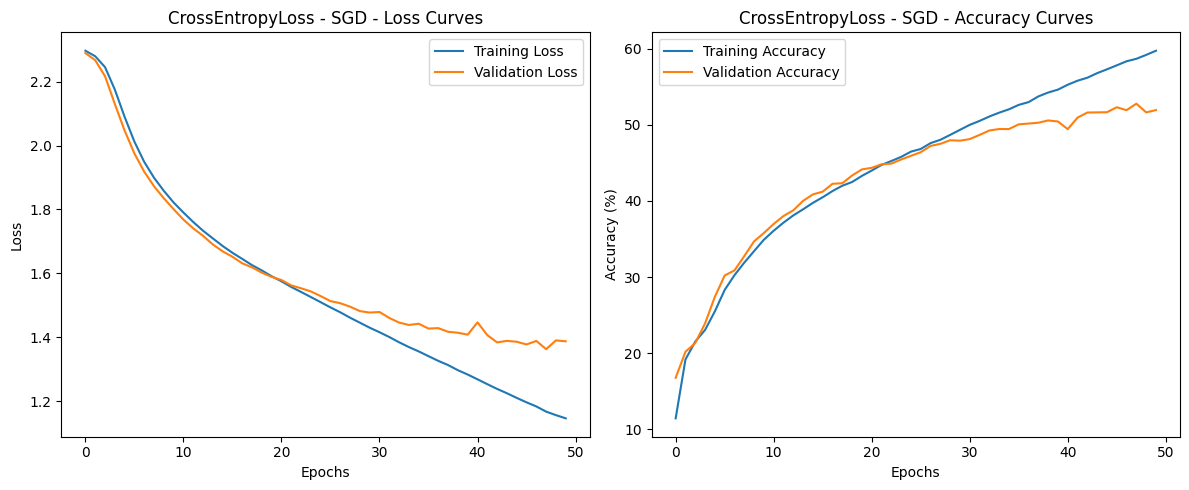

Model saved to model/cifar10_fcnn_CrossEntropyLoss_SGD.pth


In [11]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

### CrossEntropy Loss + Momentum

Running experiment with CrossEntropyLoss, SGD


Epoch 1/50: 100%|██████████| 157/157 [00:02<00:00, 57.21it/s, loss: 2.1257 - acc: 23.66%]


Epoch 1/50 - loss: 2.1257 - acc: 23.66% - val_loss: 1.8872 - val_acc: 32.16%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 58.74it/s, loss: 1.7632 - acc: 36.65%]


Epoch 2/50 - loss: 1.7632 - acc: 36.65% - val_loss: 1.6533 - val_acc: 40.93%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 58.57it/s, loss: 1.5962 - acc: 42.91%]


Epoch 3/50 - loss: 1.5962 - acc: 42.91% - val_loss: 1.5509 - val_acc: 45.12%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 59.52it/s, loss: 1.4877 - acc: 47.20%]


Epoch 4/50 - loss: 1.4877 - acc: 47.20% - val_loss: 1.4740 - val_acc: 48.18%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 58.54it/s, loss: 1.4031 - acc: 50.44%]


Epoch 5/50 - loss: 1.4031 - acc: 50.44% - val_loss: 1.4562 - val_acc: 49.12%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 58.75it/s, loss: 1.3274 - acc: 53.20%]


Epoch 6/50 - loss: 1.3274 - acc: 53.20% - val_loss: 1.3757 - val_acc: 52.12%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 58.58it/s, loss: 1.2670 - acc: 55.10%]


Epoch 7/50 - loss: 1.2670 - acc: 55.10% - val_loss: 1.3741 - val_acc: 51.86%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 58.53it/s, loss: 1.2051 - acc: 57.30%]


Epoch 8/50 - loss: 1.2051 - acc: 57.30% - val_loss: 1.3605 - val_acc: 52.18%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 57.91it/s, loss: 1.1549 - acc: 59.22%]


Epoch 9/50 - loss: 1.1549 - acc: 59.22% - val_loss: 1.3542 - val_acc: 53.00%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 59.25it/s, loss: 1.0996 - acc: 61.23%]


Epoch 10/50 - loss: 1.0996 - acc: 61.23% - val_loss: 1.3693 - val_acc: 53.13%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 58.55it/s, loss: 1.0491 - acc: 63.19%]


Epoch 11/50 - loss: 1.0491 - acc: 63.19% - val_loss: 1.3723 - val_acc: 53.87%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 58.52it/s, loss: 0.9864 - acc: 65.10%]


Epoch 12/50 - loss: 0.9864 - acc: 65.10% - val_loss: 1.3811 - val_acc: 53.17%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 58.73it/s, loss: 0.9461 - acc: 66.65%]


Epoch 13/50 - loss: 0.9461 - acc: 66.65% - val_loss: 1.4035 - val_acc: 53.22%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 58.62it/s, loss: 0.9083 - acc: 68.03%]


Epoch 14/50 - loss: 0.9083 - acc: 68.03% - val_loss: 1.3903 - val_acc: 53.87%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 58.53it/s, loss: 0.8425 - acc: 70.31%]


Epoch 15/50 - loss: 0.8425 - acc: 70.31% - val_loss: 1.4357 - val_acc: 53.95%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 58.48it/s, loss: 0.8077 - acc: 71.68%]


Epoch 16/50 - loss: 0.8077 - acc: 71.68% - val_loss: 1.4452 - val_acc: 54.62%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 59.12it/s, loss: 0.7696 - acc: 72.81%]


Epoch 17/50 - loss: 0.7696 - acc: 72.81% - val_loss: 1.4615 - val_acc: 54.28%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 58.48it/s, loss: 0.7147 - acc: 74.91%]


Epoch 18/50 - loss: 0.7147 - acc: 74.91% - val_loss: 1.5310 - val_acc: 53.97%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 58.53it/s, loss: 0.6679 - acc: 76.56%]


Epoch 19/50 - loss: 0.6679 - acc: 76.56% - val_loss: 1.5493 - val_acc: 53.29%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 58.81it/s, loss: 0.6300 - acc: 77.93%]


Epoch 20/50 - loss: 0.6300 - acc: 77.93% - val_loss: 1.6227 - val_acc: 52.95%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 57.53it/s, loss: 0.5946 - acc: 79.00%]


Epoch 21/50 - loss: 0.5946 - acc: 79.00% - val_loss: 1.6257 - val_acc: 53.27%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 58.51it/s, loss: 0.5437 - acc: 80.87%]


Epoch 22/50 - loss: 0.5437 - acc: 80.87% - val_loss: 1.6361 - val_acc: 54.29%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 58.53it/s, loss: 0.5089 - acc: 82.25%]


Epoch 23/50 - loss: 0.5089 - acc: 82.25% - val_loss: 1.6989 - val_acc: 54.39%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 58.13it/s, loss: 0.4679 - acc: 83.53%]


Epoch 24/50 - loss: 0.4679 - acc: 83.53% - val_loss: 1.8238 - val_acc: 53.49%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 58.65it/s, loss: 0.4393 - acc: 84.56%]


Epoch 25/50 - loss: 0.4393 - acc: 84.56% - val_loss: 1.8763 - val_acc: 53.38%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 58.72it/s, loss: 0.4319 - acc: 84.99%]


Epoch 26/50 - loss: 0.4319 - acc: 84.99% - val_loss: 1.9742 - val_acc: 52.68%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 58.47it/s, loss: 0.3549 - acc: 87.62%]


Epoch 27/50 - loss: 0.3549 - acc: 87.62% - val_loss: 2.0320 - val_acc: 53.27%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 58.55it/s, loss: 0.3620 - acc: 87.26%]


Epoch 28/50 - loss: 0.3620 - acc: 87.26% - val_loss: 2.0969 - val_acc: 53.07%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 59.30it/s, loss: 0.3207 - acc: 88.88%]


Epoch 29/50 - loss: 0.3207 - acc: 88.88% - val_loss: 2.1782 - val_acc: 52.37%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 58.75it/s, loss: 0.2965 - acc: 89.65%]


Epoch 30/50 - loss: 0.2965 - acc: 89.65% - val_loss: 2.3166 - val_acc: 52.87%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 58.56it/s, loss: 0.2924 - acc: 89.92%]


Epoch 31/50 - loss: 0.2924 - acc: 89.92% - val_loss: 2.2702 - val_acc: 52.53%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 58.48it/s, loss: 0.2562 - acc: 91.06%]


Epoch 32/50 - loss: 0.2562 - acc: 91.06% - val_loss: 2.3807 - val_acc: 53.43%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 58.55it/s, loss: 0.2201 - acc: 92.41%]


Epoch 33/50 - loss: 0.2201 - acc: 92.41% - val_loss: 2.4476 - val_acc: 52.97%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 58.54it/s, loss: 0.2306 - acc: 92.14%]


Epoch 34/50 - loss: 0.2306 - acc: 92.14% - val_loss: 2.5879 - val_acc: 52.40%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 58.56it/s, loss: 0.2159 - acc: 92.50%]


Epoch 35/50 - loss: 0.2159 - acc: 92.50% - val_loss: 2.5816 - val_acc: 53.36%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 59.30it/s, loss: 0.1938 - acc: 93.33%]


Epoch 36/50 - loss: 0.1938 - acc: 93.33% - val_loss: 2.7074 - val_acc: 53.34%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 58.51it/s, loss: 0.1806 - acc: 93.89%]


Epoch 37/50 - loss: 0.1806 - acc: 93.89% - val_loss: 2.7202 - val_acc: 54.18%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 58.55it/s, loss: 0.1372 - acc: 95.32%]


Epoch 38/50 - loss: 0.1372 - acc: 95.32% - val_loss: 2.7664 - val_acc: 54.06%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 58.34it/s, loss: 0.1727 - acc: 94.07%]


Epoch 39/50 - loss: 0.1727 - acc: 94.07% - val_loss: 2.9171 - val_acc: 52.65%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 58.69it/s, loss: 0.1725 - acc: 94.28%]


Epoch 40/50 - loss: 0.1725 - acc: 94.28% - val_loss: 2.9066 - val_acc: 53.67%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 58.50it/s, loss: 0.1667 - acc: 94.22%]


Epoch 41/50 - loss: 0.1667 - acc: 94.22% - val_loss: 3.0882 - val_acc: 51.94%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 58.57it/s, loss: 0.1511 - acc: 94.86%]


Epoch 42/50 - loss: 0.1511 - acc: 94.86% - val_loss: 3.0326 - val_acc: 53.26%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 59.36it/s, loss: 0.1065 - acc: 96.41%]


Epoch 43/50 - loss: 0.1065 - acc: 96.41% - val_loss: 3.2592 - val_acc: 52.06%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 58.72it/s, loss: 0.0970 - acc: 96.75%]


Epoch 44/50 - loss: 0.0970 - acc: 96.75% - val_loss: 3.2610 - val_acc: 53.84%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 58.65it/s, loss: 0.1173 - acc: 95.94%]


Epoch 45/50 - loss: 0.1173 - acc: 95.94% - val_loss: 3.2587 - val_acc: 52.95%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 58.12it/s, loss: 0.1084 - acc: 96.20%]


Epoch 46/50 - loss: 0.1084 - acc: 96.20% - val_loss: 3.1946 - val_acc: 52.75%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 58.59it/s, loss: 0.0907 - acc: 97.03%]


Epoch 47/50 - loss: 0.0907 - acc: 97.03% - val_loss: 3.2410 - val_acc: 54.27%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 58.66it/s, loss: 0.0813 - acc: 97.28%]


Epoch 48/50 - loss: 0.0813 - acc: 97.28% - val_loss: 3.3721 - val_acc: 53.70%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 59.20it/s, loss: 0.1033 - acc: 96.45%]


Epoch 49/50 - loss: 0.1033 - acc: 96.45% - val_loss: 3.4085 - val_acc: 52.83%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 58.61it/s, loss: 0.1003 - acc: 96.58%]


Epoch 50/50 - loss: 0.1003 - acc: 96.58% - val_loss: 3.5974 - val_acc: 52.55%
Training completed in 163.14 seconds
Test Accuracy: 52.55%
Accuracy of plane: 47.63%
Accuracy of car: 60.63%
Accuracy of bird: 41.83%
Accuracy of cat: 35.71%
Accuracy of deer: 41.00%
Accuracy of dog: 44.72%
Accuracy of frog: 61.82%
Accuracy of horse: 53.16%
Accuracy of ship: 75.80%
Accuracy of truck: 63.23%
Test Accuracy: 52.55%


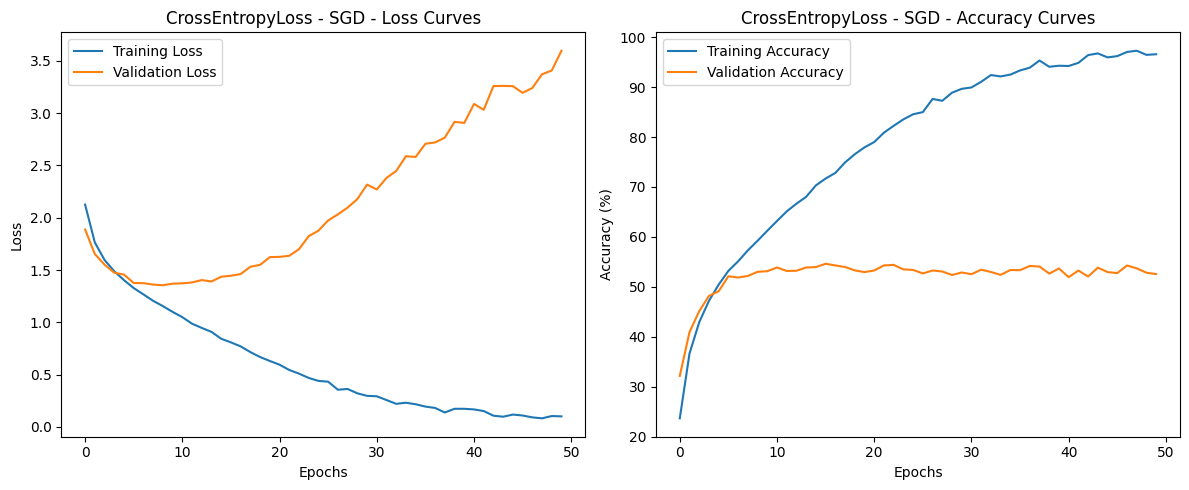

Model saved to model/cifar10_fcnn_CrossEntropyLoss_SGD.pth


In [12]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

### CrossEntropy Loss + Adagrad

Running experiment with CrossEntropyLoss, Adagrad


Epoch 1/50: 100%|██████████| 157/157 [00:02<00:00, 56.10it/s, loss: 1.7808 - acc: 37.83%]


Epoch 1/50 - loss: 1.7808 - acc: 37.83% - val_loss: 1.6262 - val_acc: 43.32%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 57.39it/s, loss: 1.4694 - acc: 48.15%]


Epoch 2/50 - loss: 1.4694 - acc: 48.15% - val_loss: 1.4734 - val_acc: 48.09%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 57.63it/s, loss: 1.3425 - acc: 52.64%]


Epoch 3/50 - loss: 1.3425 - acc: 52.64% - val_loss: 1.4724 - val_acc: 48.33%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 57.61it/s, loss: 1.2517 - acc: 56.01%]


Epoch 4/50 - loss: 1.2517 - acc: 56.01% - val_loss: 1.4184 - val_acc: 50.66%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 56.51it/s, loss: 1.1734 - acc: 58.68%]


Epoch 5/50 - loss: 1.1734 - acc: 58.68% - val_loss: 1.3939 - val_acc: 51.45%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 58.26it/s, loss: 1.0986 - acc: 61.61%]


Epoch 6/50 - loss: 1.0986 - acc: 61.61% - val_loss: 1.5068 - val_acc: 49.65%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 57.68it/s, loss: 1.0369 - acc: 63.74%]


Epoch 7/50 - loss: 1.0369 - acc: 63.74% - val_loss: 1.4150 - val_acc: 52.40%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 57.06it/s, loss: 0.9742 - acc: 66.05%]


Epoch 8/50 - loss: 0.9742 - acc: 66.05% - val_loss: 1.4410 - val_acc: 52.24%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 57.68it/s, loss: 0.9098 - acc: 68.39%]


Epoch 9/50 - loss: 0.9098 - acc: 68.39% - val_loss: 1.4338 - val_acc: 53.36%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 57.55it/s, loss: 0.8478 - acc: 70.68%]


Epoch 10/50 - loss: 0.8478 - acc: 70.68% - val_loss: 1.4789 - val_acc: 52.75%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 57.32it/s, loss: 0.7928 - acc: 72.61%]


Epoch 11/50 - loss: 0.7928 - acc: 72.61% - val_loss: 1.5131 - val_acc: 52.35%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 58.37it/s, loss: 0.7388 - acc: 74.75%]


Epoch 12/50 - loss: 0.7388 - acc: 74.75% - val_loss: 1.5085 - val_acc: 53.21%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 57.66it/s, loss: 0.6849 - acc: 76.56%]


Epoch 13/50 - loss: 0.6849 - acc: 76.56% - val_loss: 1.7032 - val_acc: 50.45%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 57.59it/s, loss: 0.6356 - acc: 78.33%]


Epoch 14/50 - loss: 0.6356 - acc: 78.33% - val_loss: 1.5970 - val_acc: 52.53%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 57.75it/s, loss: 0.5835 - acc: 80.28%]


Epoch 15/50 - loss: 0.5835 - acc: 80.28% - val_loss: 1.6115 - val_acc: 53.17%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 57.64it/s, loss: 0.5389 - acc: 81.95%]


Epoch 16/50 - loss: 0.5389 - acc: 81.95% - val_loss: 1.7450 - val_acc: 51.15%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 58.39it/s, loss: 0.4971 - acc: 83.53%]


Epoch 17/50 - loss: 0.4971 - acc: 83.53% - val_loss: 1.7694 - val_acc: 52.29%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 57.76it/s, loss: 0.4529 - acc: 85.24%]


Epoch 18/50 - loss: 0.4529 - acc: 85.24% - val_loss: 1.7210 - val_acc: 52.77%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 57.75it/s, loss: 0.4137 - acc: 86.83%]


Epoch 19/50 - loss: 0.4137 - acc: 86.83% - val_loss: 1.9090 - val_acc: 52.01%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 57.43it/s, loss: 0.3775 - acc: 88.26%]


Epoch 20/50 - loss: 0.3775 - acc: 88.26% - val_loss: 1.8551 - val_acc: 52.23%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 57.67it/s, loss: 0.3438 - acc: 89.41%]


Epoch 21/50 - loss: 0.3438 - acc: 89.41% - val_loss: 1.8324 - val_acc: 53.44%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 57.89it/s, loss: 0.3072 - acc: 90.86%]


Epoch 22/50 - loss: 0.3072 - acc: 90.86% - val_loss: 1.9425 - val_acc: 53.57%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 58.41it/s, loss: 0.2759 - acc: 92.03%]


Epoch 23/50 - loss: 0.2759 - acc: 92.03% - val_loss: 2.0766 - val_acc: 51.38%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 57.59it/s, loss: 0.2531 - acc: 92.83%]


Epoch 24/50 - loss: 0.2531 - acc: 92.83% - val_loss: 2.0748 - val_acc: 53.25%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 57.60it/s, loss: 0.2228 - acc: 93.85%]


Epoch 25/50 - loss: 0.2228 - acc: 93.85% - val_loss: 2.1181 - val_acc: 53.03%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 57.61it/s, loss: 0.2027 - acc: 94.50%]


Epoch 26/50 - loss: 0.2027 - acc: 94.50% - val_loss: 2.2808 - val_acc: 52.00%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 57.40it/s, loss: 0.1858 - acc: 95.14%]


Epoch 27/50 - loss: 0.1858 - acc: 95.14% - val_loss: 2.3009 - val_acc: 52.44%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 58.18it/s, loss: 0.1597 - acc: 96.00%]


Epoch 28/50 - loss: 0.1597 - acc: 96.00% - val_loss: 2.3451 - val_acc: 52.85%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 57.17it/s, loss: 0.1431 - acc: 96.53%]


Epoch 29/50 - loss: 0.1431 - acc: 96.53% - val_loss: 2.3600 - val_acc: 53.17%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 57.29it/s, loss: 0.1268 - acc: 97.10%]


Epoch 30/50 - loss: 0.1268 - acc: 97.10% - val_loss: 2.4720 - val_acc: 52.44%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 57.57it/s, loss: 0.1108 - acc: 97.66%]


Epoch 31/50 - loss: 0.1108 - acc: 97.66% - val_loss: 2.5298 - val_acc: 51.93%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 57.62it/s, loss: 0.1010 - acc: 97.88%]


Epoch 32/50 - loss: 0.1010 - acc: 97.88% - val_loss: 2.5284 - val_acc: 53.48%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 57.60it/s, loss: 0.0865 - acc: 98.40%]


Epoch 33/50 - loss: 0.0865 - acc: 98.40% - val_loss: 2.6074 - val_acc: 53.43%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 58.08it/s, loss: 0.0785 - acc: 98.52%]


Epoch 34/50 - loss: 0.0785 - acc: 98.52% - val_loss: 2.6671 - val_acc: 52.64%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 57.53it/s, loss: 0.0680 - acc: 98.86%]


Epoch 35/50 - loss: 0.0680 - acc: 98.86% - val_loss: 2.8088 - val_acc: 51.58%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 57.40it/s, loss: 0.0619 - acc: 99.03%]


Epoch 36/50 - loss: 0.0619 - acc: 99.03% - val_loss: 2.7497 - val_acc: 53.12%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 56.43it/s, loss: 0.0518 - acc: 99.33%]


Epoch 37/50 - loss: 0.0518 - acc: 99.33% - val_loss: 2.7836 - val_acc: 53.15%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 57.23it/s, loss: 0.0455 - acc: 99.45%]


Epoch 38/50 - loss: 0.0455 - acc: 99.45% - val_loss: 2.8373 - val_acc: 53.58%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 57.93it/s, loss: 0.0405 - acc: 99.50%]


Epoch 39/50 - loss: 0.0405 - acc: 99.50% - val_loss: 2.8898 - val_acc: 53.13%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 57.55it/s, loss: 0.0837 - acc: 98.39%]


Epoch 40/50 - loss: 0.0837 - acc: 98.39% - val_loss: 2.8290 - val_acc: 53.53%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 57.36it/s, loss: 0.0406 - acc: 99.58%]


Epoch 41/50 - loss: 0.0406 - acc: 99.58% - val_loss: 2.9072 - val_acc: 53.73%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 57.45it/s, loss: 0.0300 - acc: 99.75%]


Epoch 42/50 - loss: 0.0300 - acc: 99.75% - val_loss: 3.2548 - val_acc: 51.90%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 57.37it/s, loss: 0.0583 - acc: 98.89%]


Epoch 43/50 - loss: 0.0583 - acc: 98.89% - val_loss: 3.0198 - val_acc: 53.30%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 57.48it/s, loss: 0.0274 - acc: 99.77%]


Epoch 44/50 - loss: 0.0274 - acc: 99.77% - val_loss: 3.0395 - val_acc: 53.50%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 57.56it/s, loss: 0.0217 - acc: 99.89%]


Epoch 45/50 - loss: 0.0217 - acc: 99.89% - val_loss: 3.0880 - val_acc: 53.19%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 58.01it/s, loss: 0.0204 - acc: 99.86%]


Epoch 46/50 - loss: 0.0204 - acc: 99.86% - val_loss: 3.1329 - val_acc: 53.38%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 57.49it/s, loss: 0.0181 - acc: 99.91%]


Epoch 47/50 - loss: 0.0181 - acc: 99.91% - val_loss: 3.1681 - val_acc: 53.51%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 57.35it/s, loss: 0.0159 - acc: 99.95%]


Epoch 48/50 - loss: 0.0159 - acc: 99.95% - val_loss: 3.2292 - val_acc: 53.03%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 57.55it/s, loss: 0.0150 - acc: 99.94%]


Epoch 49/50 - loss: 0.0150 - acc: 99.94% - val_loss: 3.2408 - val_acc: 53.42%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 57.60it/s, loss: 0.0134 - acc: 99.96%]


Epoch 50/50 - loss: 0.0134 - acc: 99.96% - val_loss: 3.2751 - val_acc: 53.31%
Training completed in 165.53 seconds
Test Accuracy: 53.31%
Accuracy of plane: 55.20%
Accuracy of car: 65.08%
Accuracy of bird: 44.52%
Accuracy of cat: 37.46%
Accuracy of deer: 46.52%
Accuracy of dog: 42.38%
Accuracy of frog: 55.12%
Accuracy of horse: 59.37%
Accuracy of ship: 70.50%
Accuracy of truck: 57.16%
Test Accuracy: 53.31%


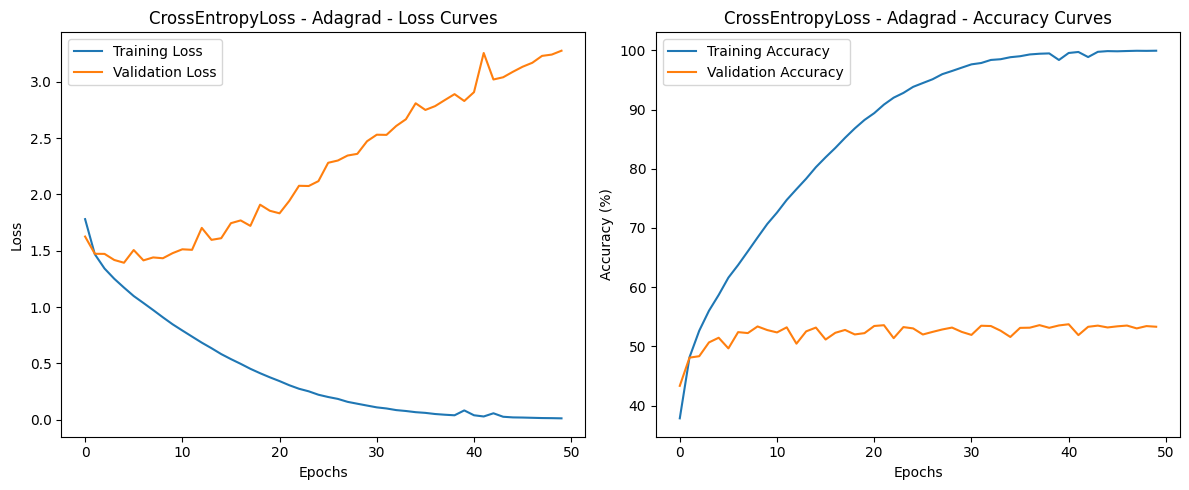

Model saved to model/cifar10_fcnn_CrossEntropyLoss_Adagrad.pth


In [13]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

### CrossEntropy Loss + Adam

Running experiment with CrossEntropyLoss, Adam


Epoch 1/50: 100%|██████████| 157/157 [00:02<00:00, 54.06it/s, loss: 1.7135 - acc: 38.63%]


Epoch 1/50 - loss: 1.7135 - acc: 38.63% - val_loss: 1.5568 - val_acc: 45.34%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 55.30it/s, loss: 1.4742 - acc: 47.72%]


Epoch 2/50 - loss: 1.4742 - acc: 47.72% - val_loss: 1.4430 - val_acc: 49.72%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 55.24it/s, loss: 1.3473 - acc: 52.48%]


Epoch 3/50 - loss: 1.3473 - acc: 52.48% - val_loss: 1.4163 - val_acc: 50.41%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 55.01it/s, loss: 1.2521 - acc: 55.73%]


Epoch 4/50 - loss: 1.2521 - acc: 55.73% - val_loss: 1.3675 - val_acc: 52.50%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 55.86it/s, loss: 1.1579 - acc: 59.54%]


Epoch 5/50 - loss: 1.1579 - acc: 59.54% - val_loss: 1.3545 - val_acc: 52.67%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 55.32it/s, loss: 1.0723 - acc: 62.05%]


Epoch 6/50 - loss: 1.0723 - acc: 62.05% - val_loss: 1.3741 - val_acc: 52.85%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 55.26it/s, loss: 0.9813 - acc: 65.44%]


Epoch 7/50 - loss: 0.9813 - acc: 65.44% - val_loss: 1.3897 - val_acc: 53.44%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 55.23it/s, loss: 0.9066 - acc: 67.67%]


Epoch 8/50 - loss: 0.9066 - acc: 67.67% - val_loss: 1.4116 - val_acc: 53.38%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 54.69it/s, loss: 0.8238 - acc: 70.91%]


Epoch 9/50 - loss: 0.8238 - acc: 70.91% - val_loss: 1.4618 - val_acc: 53.90%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 55.91it/s, loss: 0.7475 - acc: 73.55%]


Epoch 10/50 - loss: 0.7475 - acc: 73.55% - val_loss: 1.4718 - val_acc: 54.63%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 55.55it/s, loss: 0.6583 - acc: 76.49%]


Epoch 11/50 - loss: 0.6583 - acc: 76.49% - val_loss: 1.6023 - val_acc: 53.61%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 55.37it/s, loss: 0.5917 - acc: 78.78%]


Epoch 12/50 - loss: 0.5917 - acc: 78.78% - val_loss: 1.6694 - val_acc: 53.45%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 54.06it/s, loss: 0.5323 - acc: 80.95%]


Epoch 13/50 - loss: 0.5323 - acc: 80.95% - val_loss: 1.7585 - val_acc: 53.92%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 55.45it/s, loss: 0.4696 - acc: 83.14%]


Epoch 14/50 - loss: 0.4696 - acc: 83.14% - val_loss: 1.9655 - val_acc: 52.94%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 55.53it/s, loss: 0.4207 - acc: 84.78%]


Epoch 15/50 - loss: 0.4207 - acc: 84.78% - val_loss: 2.0305 - val_acc: 53.30%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 54.56it/s, loss: 0.3661 - acc: 87.08%]


Epoch 16/50 - loss: 0.3661 - acc: 87.08% - val_loss: 2.1716 - val_acc: 53.08%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 55.46it/s, loss: 0.3371 - acc: 88.11%]


Epoch 17/50 - loss: 0.3371 - acc: 88.11% - val_loss: 2.3486 - val_acc: 52.40%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 55.45it/s, loss: 0.2955 - acc: 89.56%]


Epoch 18/50 - loss: 0.2955 - acc: 89.56% - val_loss: 2.4391 - val_acc: 52.53%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 55.25it/s, loss: 0.2859 - acc: 89.81%]


Epoch 19/50 - loss: 0.2859 - acc: 89.81% - val_loss: 2.4712 - val_acc: 53.43%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 55.38it/s, loss: 0.2183 - acc: 92.44%]


Epoch 20/50 - loss: 0.2183 - acc: 92.44% - val_loss: 2.7875 - val_acc: 52.17%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 55.16it/s, loss: 0.2118 - acc: 92.44%]


Epoch 21/50 - loss: 0.2118 - acc: 92.44% - val_loss: 2.7857 - val_acc: 53.18%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 55.95it/s, loss: 0.2097 - acc: 92.79%]


Epoch 22/50 - loss: 0.2097 - acc: 92.79% - val_loss: 2.9330 - val_acc: 53.29%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 55.39it/s, loss: 0.1867 - acc: 93.54%]


Epoch 23/50 - loss: 0.1867 - acc: 93.54% - val_loss: 2.9925 - val_acc: 52.31%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 55.37it/s, loss: 0.2062 - acc: 92.92%]


Epoch 24/50 - loss: 0.2062 - acc: 92.92% - val_loss: 3.0884 - val_acc: 51.88%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 55.41it/s, loss: 0.1734 - acc: 93.83%]


Epoch 25/50 - loss: 0.1734 - acc: 93.83% - val_loss: 3.1770 - val_acc: 53.42%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 55.30it/s, loss: 0.1649 - acc: 94.30%]


Epoch 26/50 - loss: 0.1649 - acc: 94.30% - val_loss: 3.3716 - val_acc: 52.39%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 55.43it/s, loss: 0.1525 - acc: 94.82%]


Epoch 27/50 - loss: 0.1525 - acc: 94.82% - val_loss: 3.3018 - val_acc: 52.97%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 55.41it/s, loss: 0.1400 - acc: 95.23%]


Epoch 28/50 - loss: 0.1400 - acc: 95.23% - val_loss: 3.5515 - val_acc: 52.96%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 56.03it/s, loss: 0.1369 - acc: 95.30%]


Epoch 29/50 - loss: 0.1369 - acc: 95.30% - val_loss: 3.6163 - val_acc: 52.33%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 55.15it/s, loss: 0.1323 - acc: 95.46%]


Epoch 30/50 - loss: 0.1323 - acc: 95.46% - val_loss: 3.7291 - val_acc: 52.36%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 55.29it/s, loss: 0.1363 - acc: 95.30%]


Epoch 31/50 - loss: 0.1363 - acc: 95.30% - val_loss: 3.6430 - val_acc: 52.44%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 55.25it/s, loss: 0.1223 - acc: 95.83%]


Epoch 32/50 - loss: 0.1223 - acc: 95.83% - val_loss: 3.8128 - val_acc: 52.74%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 55.36it/s, loss: 0.1514 - acc: 94.78%]


Epoch 33/50 - loss: 0.1514 - acc: 94.78% - val_loss: 3.7845 - val_acc: 52.17%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 55.43it/s, loss: 0.1196 - acc: 95.95%]


Epoch 34/50 - loss: 0.1196 - acc: 95.95% - val_loss: 3.8259 - val_acc: 53.40%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 55.29it/s, loss: 0.1132 - acc: 96.21%]


Epoch 35/50 - loss: 0.1132 - acc: 96.21% - val_loss: 3.9286 - val_acc: 51.79%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 56.27it/s, loss: 0.1160 - acc: 96.06%]


Epoch 36/50 - loss: 0.1160 - acc: 96.06% - val_loss: 3.8403 - val_acc: 52.61%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 55.60it/s, loss: 0.1299 - acc: 95.58%]


Epoch 37/50 - loss: 0.1299 - acc: 95.58% - val_loss: 3.8867 - val_acc: 52.81%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 55.57it/s, loss: 0.1116 - acc: 96.18%]


Epoch 38/50 - loss: 0.1116 - acc: 96.18% - val_loss: 3.9882 - val_acc: 52.67%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 55.26it/s, loss: 0.0823 - acc: 97.19%]


Epoch 39/50 - loss: 0.0823 - acc: 97.19% - val_loss: 4.4465 - val_acc: 52.45%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 55.76it/s, loss: 0.0786 - acc: 97.33%]


Epoch 40/50 - loss: 0.0786 - acc: 97.33% - val_loss: 4.2902 - val_acc: 53.56%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 56.44it/s, loss: 0.1106 - acc: 96.28%]


Epoch 41/50 - loss: 0.1106 - acc: 96.28% - val_loss: 4.1883 - val_acc: 52.00%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 55.80it/s, loss: 0.1325 - acc: 95.66%]


Epoch 42/50 - loss: 0.1325 - acc: 95.66% - val_loss: 4.3138 - val_acc: 52.54%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 55.73it/s, loss: 0.1134 - acc: 96.15%]


Epoch 43/50 - loss: 0.1134 - acc: 96.15% - val_loss: 4.3376 - val_acc: 53.17%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 55.58it/s, loss: 0.1008 - acc: 96.53%]


Epoch 44/50 - loss: 0.1008 - acc: 96.53% - val_loss: 4.2937 - val_acc: 53.25%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 55.73it/s, loss: 0.0772 - acc: 97.58%]


Epoch 45/50 - loss: 0.0772 - acc: 97.58% - val_loss: 4.3981 - val_acc: 52.90%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 55.71it/s, loss: 0.0730 - acc: 97.54%]


Epoch 46/50 - loss: 0.0730 - acc: 97.54% - val_loss: 4.4772 - val_acc: 53.24%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 55.82it/s, loss: 0.0665 - acc: 97.77%]


Epoch 47/50 - loss: 0.0665 - acc: 97.77% - val_loss: 4.6643 - val_acc: 52.38%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 55.93it/s, loss: 0.1000 - acc: 96.74%]


Epoch 48/50 - loss: 0.1000 - acc: 96.74% - val_loss: 4.4932 - val_acc: 53.05%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 55.67it/s, loss: 0.1247 - acc: 95.97%]


Epoch 49/50 - loss: 0.1247 - acc: 95.97% - val_loss: 4.2545 - val_acc: 52.72%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 55.64it/s, loss: 0.0950 - acc: 96.88%]


Epoch 50/50 - loss: 0.0950 - acc: 96.88% - val_loss: 4.5597 - val_acc: 53.04%
Training completed in 170.73 seconds
Test Accuracy: 53.04%
Accuracy of plane: 58.22%
Accuracy of car: 67.41%
Accuracy of bird: 40.14%
Accuracy of cat: 29.46%
Accuracy of deer: 51.23%
Accuracy of dog: 44.00%
Accuracy of frog: 55.02%
Accuracy of horse: 56.51%
Accuracy of ship: 69.10%
Accuracy of truck: 60.04%
Test Accuracy: 53.04%


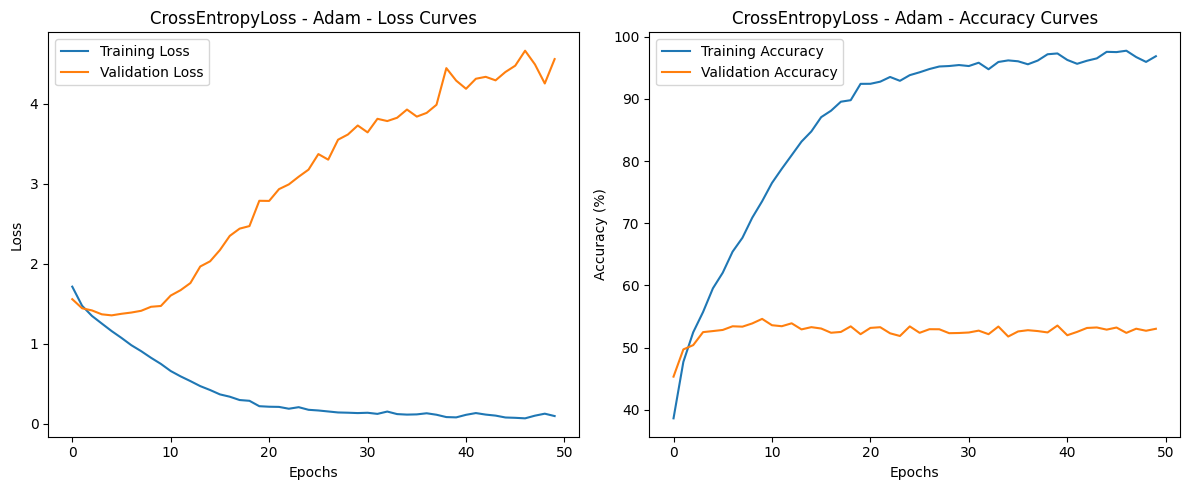

Model saved to model/cifar10_fcnn_CrossEntropyLoss_Adam.pth


In [14]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

### CrossEntropy Loss + Adamax

Running experiment with CrossEntropyLoss, Adamax


Epoch 1/50: 100%|██████████| 157/157 [00:02<00:00, 54.91it/s, loss: 1.7362 - acc: 38.13%]


Epoch 1/50 - loss: 1.7362 - acc: 38.13% - val_loss: 1.5725 - val_acc: 44.83%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 56.23it/s, loss: 1.5048 - acc: 46.93%]


Epoch 2/50 - loss: 1.5048 - acc: 46.93% - val_loss: 1.4874 - val_acc: 48.39%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 56.35it/s, loss: 1.3906 - acc: 51.22%]


Epoch 3/50 - loss: 1.3906 - acc: 51.22% - val_loss: 1.4391 - val_acc: 49.82%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 55.99it/s, loss: 1.3111 - acc: 54.07%]


Epoch 4/50 - loss: 1.3111 - acc: 54.07% - val_loss: 1.3950 - val_acc: 51.73%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 56.21it/s, loss: 1.2342 - acc: 57.05%]


Epoch 5/50 - loss: 1.2342 - acc: 57.05% - val_loss: 1.3839 - val_acc: 51.62%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 56.29it/s, loss: 1.1716 - acc: 58.96%]


Epoch 6/50 - loss: 1.1716 - acc: 58.96% - val_loss: 1.3471 - val_acc: 53.61%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 56.97it/s, loss: 1.1005 - acc: 61.62%]


Epoch 7/50 - loss: 1.1005 - acc: 61.62% - val_loss: 1.3395 - val_acc: 53.98%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 56.32it/s, loss: 1.0395 - acc: 63.93%]


Epoch 8/50 - loss: 1.0395 - acc: 63.93% - val_loss: 1.3414 - val_acc: 54.32%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 56.35it/s, loss: 0.9727 - acc: 66.21%]


Epoch 9/50 - loss: 0.9727 - acc: 66.21% - val_loss: 1.3674 - val_acc: 54.72%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 56.47it/s, loss: 0.9158 - acc: 68.22%]


Epoch 10/50 - loss: 0.9158 - acc: 68.22% - val_loss: 1.4186 - val_acc: 53.48%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 56.28it/s, loss: 0.8551 - acc: 70.37%]


Epoch 11/50 - loss: 0.8551 - acc: 70.37% - val_loss: 1.4047 - val_acc: 54.01%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 56.92it/s, loss: 0.7988 - acc: 72.47%]


Epoch 12/50 - loss: 0.7988 - acc: 72.47% - val_loss: 1.4242 - val_acc: 54.89%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 55.96it/s, loss: 0.7385 - acc: 74.67%]


Epoch 13/50 - loss: 0.7385 - acc: 74.67% - val_loss: 1.4359 - val_acc: 54.69%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 56.29it/s, loss: 0.6867 - acc: 76.56%]


Epoch 14/50 - loss: 0.6867 - acc: 76.56% - val_loss: 1.5097 - val_acc: 54.51%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 56.21it/s, loss: 0.6325 - acc: 78.25%]


Epoch 15/50 - loss: 0.6325 - acc: 78.25% - val_loss: 1.5252 - val_acc: 54.71%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 56.31it/s, loss: 0.5707 - acc: 80.61%]


Epoch 16/50 - loss: 0.5707 - acc: 80.61% - val_loss: 1.5882 - val_acc: 54.58%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 56.77it/s, loss: 0.5261 - acc: 82.35%]


Epoch 17/50 - loss: 0.5261 - acc: 82.35% - val_loss: 1.6561 - val_acc: 54.45%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 56.80it/s, loss: 0.4873 - acc: 83.44%]


Epoch 18/50 - loss: 0.4873 - acc: 83.44% - val_loss: 1.7032 - val_acc: 53.64%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 56.10it/s, loss: 0.4466 - acc: 85.12%]


Epoch 19/50 - loss: 0.4466 - acc: 85.12% - val_loss: 1.7604 - val_acc: 54.79%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 56.12it/s, loss: 0.4008 - acc: 86.70%]


Epoch 20/50 - loss: 0.4008 - acc: 86.70% - val_loss: 1.8559 - val_acc: 53.42%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 56.27it/s, loss: 0.3531 - acc: 88.52%]


Epoch 21/50 - loss: 0.3531 - acc: 88.52% - val_loss: 1.9262 - val_acc: 53.76%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 55.52it/s, loss: 0.3312 - acc: 89.22%]


Epoch 22/50 - loss: 0.3312 - acc: 89.22% - val_loss: 1.9176 - val_acc: 54.57%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 56.76it/s, loss: 0.2941 - acc: 90.50%]


Epoch 23/50 - loss: 0.2941 - acc: 90.50% - val_loss: 2.0834 - val_acc: 53.64%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 56.75it/s, loss: 0.2730 - acc: 91.03%]


Epoch 24/50 - loss: 0.2730 - acc: 91.03% - val_loss: 2.1755 - val_acc: 53.63%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 56.25it/s, loss: 0.2483 - acc: 92.13%]


Epoch 25/50 - loss: 0.2483 - acc: 92.13% - val_loss: 2.1958 - val_acc: 53.53%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 56.19it/s, loss: 0.2199 - acc: 93.08%]


Epoch 26/50 - loss: 0.2199 - acc: 93.08% - val_loss: 2.3020 - val_acc: 53.18%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 56.15it/s, loss: 0.1969 - acc: 93.89%]


Epoch 27/50 - loss: 0.1969 - acc: 93.89% - val_loss: 2.3751 - val_acc: 53.37%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 56.25it/s, loss: 0.1849 - acc: 94.09%]


Epoch 28/50 - loss: 0.1849 - acc: 94.09% - val_loss: 2.4130 - val_acc: 53.77%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 56.18it/s, loss: 0.1602 - acc: 95.01%]


Epoch 29/50 - loss: 0.1602 - acc: 95.01% - val_loss: 2.5473 - val_acc: 53.58%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 56.75it/s, loss: 0.1481 - acc: 95.36%]


Epoch 30/50 - loss: 0.1481 - acc: 95.36% - val_loss: 2.6351 - val_acc: 53.41%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 55.75it/s, loss: 0.1327 - acc: 96.07%]


Epoch 31/50 - loss: 0.1327 - acc: 96.07% - val_loss: 2.7335 - val_acc: 52.93%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 54.51it/s, loss: 0.1370 - acc: 95.78%]


Epoch 32/50 - loss: 0.1370 - acc: 95.78% - val_loss: 2.7576 - val_acc: 53.03%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 56.12it/s, loss: 0.1226 - acc: 96.18%]


Epoch 33/50 - loss: 0.1226 - acc: 96.18% - val_loss: 2.7991 - val_acc: 53.87%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 56.08it/s, loss: 0.1043 - acc: 96.78%]


Epoch 34/50 - loss: 0.1043 - acc: 96.78% - val_loss: 2.8213 - val_acc: 53.86%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 56.72it/s, loss: 0.0953 - acc: 97.17%]


Epoch 35/50 - loss: 0.0953 - acc: 97.17% - val_loss: 2.9147 - val_acc: 53.81%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 56.11it/s, loss: 0.0989 - acc: 96.99%]


Epoch 36/50 - loss: 0.0989 - acc: 96.99% - val_loss: 3.0583 - val_acc: 53.09%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 56.11it/s, loss: 0.0923 - acc: 97.19%]


Epoch 37/50 - loss: 0.0923 - acc: 97.19% - val_loss: 3.1355 - val_acc: 53.51%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 56.02it/s, loss: 0.0811 - acc: 97.59%]


Epoch 38/50 - loss: 0.0811 - acc: 97.59% - val_loss: 3.1657 - val_acc: 52.97%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 56.12it/s, loss: 0.0859 - acc: 97.30%]


Epoch 39/50 - loss: 0.0859 - acc: 97.30% - val_loss: 3.3012 - val_acc: 52.78%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 56.66it/s, loss: 0.0641 - acc: 98.15%]


Epoch 40/50 - loss: 0.0641 - acc: 98.15% - val_loss: 3.3003 - val_acc: 52.63%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 56.41it/s, loss: 0.0712 - acc: 97.94%]


Epoch 41/50 - loss: 0.0712 - acc: 97.94% - val_loss: 3.3460 - val_acc: 53.52%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 56.18it/s, loss: 0.0743 - acc: 97.66%]


Epoch 42/50 - loss: 0.0743 - acc: 97.66% - val_loss: 3.4104 - val_acc: 52.59%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 56.10it/s, loss: 0.0565 - acc: 98.35%]


Epoch 43/50 - loss: 0.0565 - acc: 98.35% - val_loss: 3.4222 - val_acc: 53.62%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 56.18it/s, loss: 0.0493 - acc: 98.68%]


Epoch 44/50 - loss: 0.0493 - acc: 98.68% - val_loss: 3.5423 - val_acc: 53.09%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 55.84it/s, loss: 0.0772 - acc: 97.57%]


Epoch 45/50 - loss: 0.0772 - acc: 97.57% - val_loss: 3.5569 - val_acc: 52.99%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 56.61it/s, loss: 0.0550 - acc: 98.33%]


Epoch 46/50 - loss: 0.0550 - acc: 98.33% - val_loss: 3.5332 - val_acc: 53.87%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 56.18it/s, loss: 0.0561 - acc: 98.26%]


Epoch 47/50 - loss: 0.0561 - acc: 98.26% - val_loss: 3.5581 - val_acc: 53.93%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 56.03it/s, loss: 0.0444 - acc: 98.68%]


Epoch 48/50 - loss: 0.0444 - acc: 98.68% - val_loss: 3.7414 - val_acc: 53.35%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 56.21it/s, loss: 0.0527 - acc: 98.38%]


Epoch 49/50 - loss: 0.0527 - acc: 98.38% - val_loss: 3.6889 - val_acc: 53.79%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 55.77it/s, loss: 0.0267 - acc: 99.33%]


Epoch 50/50 - loss: 0.0267 - acc: 99.33% - val_loss: 3.7476 - val_acc: 53.71%
Training completed in 168.82 seconds
Test Accuracy: 53.71%
Accuracy of plane: 57.92%
Accuracy of car: 63.06%
Accuracy of bird: 42.03%
Accuracy of cat: 35.12%
Accuracy of deer: 40.59%
Accuracy of dog: 48.48%
Accuracy of frog: 61.82%
Accuracy of horse: 58.38%
Accuracy of ship: 71.50%
Accuracy of truck: 58.19%
Test Accuracy: 53.71%


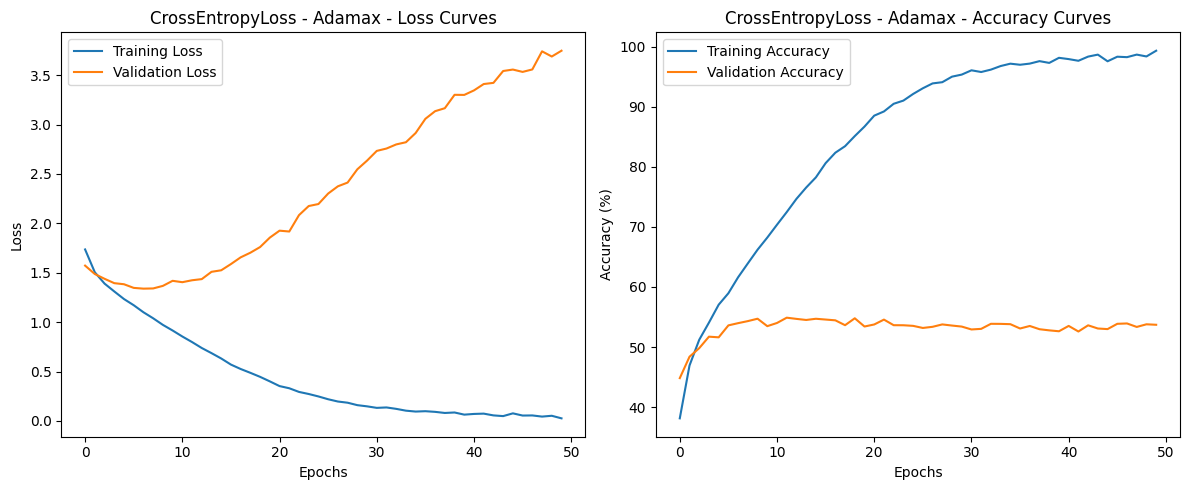

Model saved to model/cifar10_fcnn_CrossEntropyLoss_Adamax.pth


In [15]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='batchmean')
        self.smoothing = smoothing
        self.classes = classes

    def forward(self, prediction, target):
        confidence = 1.0 - self.smoothing
        true_dist = torch.zeros_like(prediction)
        true_dist.fill_(self.smoothing / (self.classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), confidence)
        return self.criterion(torch.log_softmax(prediction, dim=-1), true_dist)

### Label Smoothing Loss + SGD

Running experiment with LabelSmoothingLoss, SGD


Epoch 1/50: 100%|██████████| 157/157 [00:03<00:00, 43.48it/s, loss: 1.7545 - acc: 12.13%]


Epoch 1/50 - loss: 1.7545 - acc: 12.13% - val_loss: 1.7486 - val_acc: 15.78%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 55.69it/s, loss: 1.7411 - acc: 17.88%]


Epoch 2/50 - loss: 1.7411 - acc: 17.88% - val_loss: 1.7322 - val_acc: 20.52%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 56.07it/s, loss: 1.7178 - acc: 22.93%]


Epoch 3/50 - loss: 1.7178 - acc: 22.93% - val_loss: 1.7001 - val_acc: 23.83%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 55.27it/s, loss: 1.6729 - acc: 25.35%]


Epoch 4/50 - loss: 1.6729 - acc: 25.35% - val_loss: 1.6431 - val_acc: 26.07%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 54.47it/s, loss: 1.6117 - acc: 26.64%]


Epoch 5/50 - loss: 1.6117 - acc: 26.64% - val_loss: 1.5814 - val_acc: 26.98%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 53.68it/s, loss: 1.5567 - acc: 28.06%]


Epoch 6/50 - loss: 1.5567 - acc: 28.06% - val_loss: 1.5295 - val_acc: 28.95%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 55.06it/s, loss: 1.5107 - acc: 29.88%]


Epoch 7/50 - loss: 1.5107 - acc: 29.88% - val_loss: 1.4872 - val_acc: 31.29%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 55.23it/s, loss: 1.4731 - acc: 31.66%]


Epoch 8/50 - loss: 1.4731 - acc: 31.66% - val_loss: 1.4526 - val_acc: 32.58%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 55.75it/s, loss: 1.4427 - acc: 32.95%]


Epoch 9/50 - loss: 1.4427 - acc: 32.95% - val_loss: 1.4245 - val_acc: 34.24%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 55.50it/s, loss: 1.4167 - acc: 34.27%]


Epoch 10/50 - loss: 1.4167 - acc: 34.27% - val_loss: 1.3992 - val_acc: 34.88%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 55.89it/s, loss: 1.3930 - acc: 35.27%]


Epoch 11/50 - loss: 1.3930 - acc: 35.27% - val_loss: 1.3768 - val_acc: 36.24%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 55.78it/s, loss: 1.3704 - acc: 36.19%]


Epoch 12/50 - loss: 1.3704 - acc: 36.19% - val_loss: 1.3549 - val_acc: 36.82%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 55.98it/s, loss: 1.3501 - acc: 37.10%]


Epoch 13/50 - loss: 1.3501 - acc: 37.10% - val_loss: 1.3360 - val_acc: 37.62%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 55.74it/s, loss: 1.3320 - acc: 38.01%]


Epoch 14/50 - loss: 1.3320 - acc: 38.01% - val_loss: 1.3181 - val_acc: 38.54%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 56.37it/s, loss: 1.3146 - acc: 38.84%]


Epoch 15/50 - loss: 1.3146 - acc: 38.84% - val_loss: 1.3028 - val_acc: 39.74%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 56.09it/s, loss: 1.2993 - acc: 39.66%]


Epoch 16/50 - loss: 1.2993 - acc: 39.66% - val_loss: 1.2879 - val_acc: 40.28%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 56.09it/s, loss: 1.2841 - acc: 40.17%]


Epoch 17/50 - loss: 1.2841 - acc: 40.17% - val_loss: 1.2754 - val_acc: 40.47%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 56.07it/s, loss: 1.2707 - acc: 40.92%]


Epoch 18/50 - loss: 1.2707 - acc: 40.92% - val_loss: 1.2607 - val_acc: 41.57%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 56.28it/s, loss: 1.2576 - acc: 41.58%]


Epoch 19/50 - loss: 1.2576 - acc: 41.58% - val_loss: 1.2518 - val_acc: 41.96%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 56.00it/s, loss: 1.2442 - acc: 42.27%]


Epoch 20/50 - loss: 1.2442 - acc: 42.27% - val_loss: 1.2400 - val_acc: 42.68%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 56.12it/s, loss: 1.2329 - acc: 42.81%]


Epoch 21/50 - loss: 1.2329 - acc: 42.81% - val_loss: 1.2287 - val_acc: 43.31%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 56.26it/s, loss: 1.2208 - acc: 43.40%]


Epoch 22/50 - loss: 1.2208 - acc: 43.40% - val_loss: 1.2213 - val_acc: 43.27%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 55.95it/s, loss: 1.2094 - acc: 43.85%]


Epoch 23/50 - loss: 1.2094 - acc: 43.85% - val_loss: 1.2111 - val_acc: 44.02%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 54.41it/s, loss: 1.1986 - acc: 44.40%]


Epoch 24/50 - loss: 1.1986 - acc: 44.40% - val_loss: 1.2006 - val_acc: 44.57%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 54.12it/s, loss: 1.1879 - acc: 44.98%]


Epoch 25/50 - loss: 1.1879 - acc: 44.98% - val_loss: 1.1926 - val_acc: 45.02%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 55.02it/s, loss: 1.1774 - acc: 45.55%]


Epoch 26/50 - loss: 1.1774 - acc: 45.55% - val_loss: 1.1868 - val_acc: 45.41%


Epoch 27/50: 100%|██████████| 157/157 [00:03<00:00, 52.29it/s, loss: 1.1672 - acc: 45.99%]


Epoch 27/50 - loss: 1.1672 - acc: 45.99% - val_loss: 1.1777 - val_acc: 45.86%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 53.10it/s, loss: 1.1567 - acc: 46.55%]


Epoch 28/50 - loss: 1.1567 - acc: 46.55% - val_loss: 1.1703 - val_acc: 46.33%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 55.13it/s, loss: 1.1473 - acc: 47.03%]


Epoch 29/50 - loss: 1.1473 - acc: 47.03% - val_loss: 1.1632 - val_acc: 46.87%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 56.25it/s, loss: 1.1368 - acc: 47.50%]


Epoch 30/50 - loss: 1.1368 - acc: 47.50% - val_loss: 1.1554 - val_acc: 47.03%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 55.76it/s, loss: 1.1272 - acc: 48.02%]


Epoch 31/50 - loss: 1.1272 - acc: 48.02% - val_loss: 1.1483 - val_acc: 47.23%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 54.02it/s, loss: 1.1176 - acc: 48.49%]


Epoch 32/50 - loss: 1.1176 - acc: 48.49% - val_loss: 1.1441 - val_acc: 47.64%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 54.49it/s, loss: 1.1077 - acc: 49.12%]


Epoch 33/50 - loss: 1.1077 - acc: 49.12% - val_loss: 1.1352 - val_acc: 48.21%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 55.00it/s, loss: 1.0995 - acc: 49.55%]


Epoch 34/50 - loss: 1.0995 - acc: 49.55% - val_loss: 1.1295 - val_acc: 48.55%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 55.18it/s, loss: 1.0893 - acc: 50.01%]


Epoch 35/50 - loss: 1.0893 - acc: 50.01% - val_loss: 1.1231 - val_acc: 48.99%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 54.84it/s, loss: 1.0802 - acc: 50.59%]


Epoch 36/50 - loss: 1.0802 - acc: 50.59% - val_loss: 1.1172 - val_acc: 48.90%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 54.37it/s, loss: 1.0704 - acc: 50.98%]


Epoch 37/50 - loss: 1.0704 - acc: 50.98% - val_loss: 1.1146 - val_acc: 49.13%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 55.07it/s, loss: 1.0619 - acc: 51.30%]


Epoch 38/50 - loss: 1.0619 - acc: 51.30% - val_loss: 1.1089 - val_acc: 49.36%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 54.31it/s, loss: 1.0523 - acc: 51.93%]


Epoch 39/50 - loss: 1.0523 - acc: 51.93% - val_loss: 1.1078 - val_acc: 49.81%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 53.49it/s, loss: 1.0445 - acc: 52.35%]


Epoch 40/50 - loss: 1.0445 - acc: 52.35% - val_loss: 1.1040 - val_acc: 49.94%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 54.96it/s, loss: 1.0349 - acc: 52.81%]


Epoch 41/50 - loss: 1.0349 - acc: 52.81% - val_loss: 1.0983 - val_acc: 50.41%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 54.50it/s, loss: 1.0274 - acc: 53.30%]


Epoch 42/50 - loss: 1.0274 - acc: 53.30% - val_loss: 1.0928 - val_acc: 50.61%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 55.90it/s, loss: 1.0179 - acc: 53.70%]


Epoch 43/50 - loss: 1.0179 - acc: 53.70% - val_loss: 1.0858 - val_acc: 50.70%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 54.80it/s, loss: 1.0099 - acc: 54.12%]


Epoch 44/50 - loss: 1.0099 - acc: 54.12% - val_loss: 1.0877 - val_acc: 50.96%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 57.14it/s, loss: 1.0023 - acc: 54.59%]


Epoch 45/50 - loss: 1.0023 - acc: 54.59% - val_loss: 1.0811 - val_acc: 51.23%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 56.46it/s, loss: 0.9941 - acc: 55.01%]


Epoch 46/50 - loss: 0.9941 - acc: 55.01% - val_loss: 1.0773 - val_acc: 51.24%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 54.34it/s, loss: 0.9846 - acc: 55.44%]


Epoch 47/50 - loss: 0.9846 - acc: 55.44% - val_loss: 1.0700 - val_acc: 51.71%


Epoch 48/50: 100%|██████████| 157/157 [00:03<00:00, 51.51it/s, loss: 0.9769 - acc: 55.87%]


Epoch 48/50 - loss: 0.9769 - acc: 55.87% - val_loss: 1.0711 - val_acc: 51.53%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 53.24it/s, loss: 0.9687 - acc: 56.20%]


Epoch 49/50 - loss: 0.9687 - acc: 56.20% - val_loss: 1.0675 - val_acc: 51.91%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 53.65it/s, loss: 0.9620 - acc: 56.75%]


Epoch 50/50 - loss: 0.9620 - acc: 56.75% - val_loss: 1.0581 - val_acc: 52.32%
Training completed in 173.84 seconds
Test Accuracy: 52.32%
Accuracy of plane: 58.83%
Accuracy of car: 64.47%
Accuracy of bird: 34.46%
Accuracy of cat: 32.59%
Accuracy of deer: 44.48%
Accuracy of dog: 39.33%
Accuracy of frog: 60.48%
Accuracy of horse: 59.57%
Accuracy of ship: 70.60%
Accuracy of truck: 58.50%
Test Accuracy: 52.32%


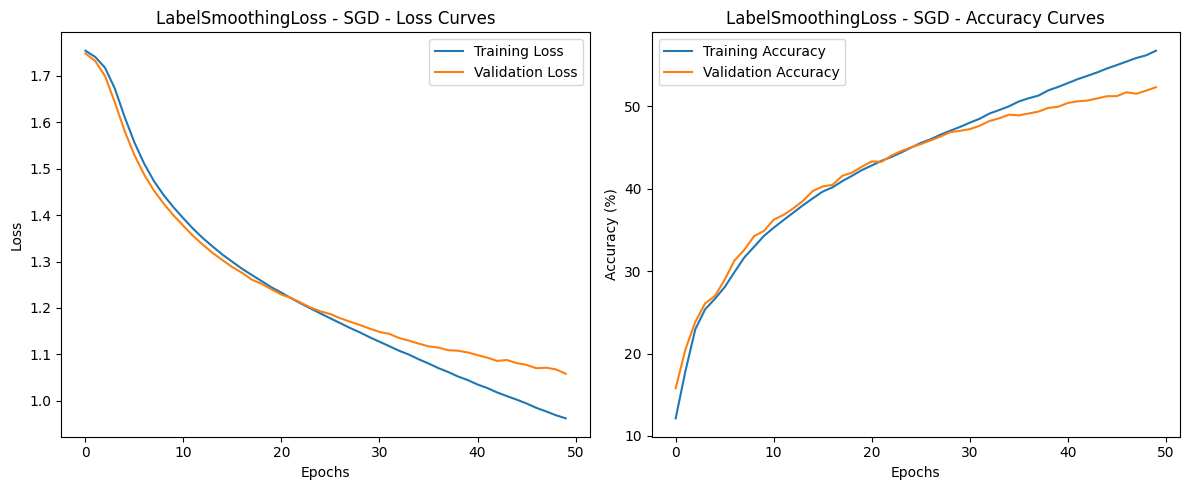

Model saved to model/cifar10_fcnn_LabelSmoothingLoss_SGD.pth


In [21]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = LabelSmoothingLoss(classes=10)
optimizer = optim.SGD(model.parameters(), lr=0.01)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

### Label Smoothing Loss + Momentum

Running experiment with LabelSmoothingLoss, SGD


Epoch 1/50: 100%|██████████| 157/157 [00:03<00:00, 52.28it/s, loss: 1.6434 - acc: 22.41%]


Epoch 1/50 - loss: 1.6434 - acc: 22.41% - val_loss: 1.4656 - val_acc: 31.16%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 55.01it/s, loss: 1.3758 - acc: 35.12%]


Epoch 2/50 - loss: 1.3758 - acc: 35.12% - val_loss: 1.2926 - val_acc: 40.29%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 54.96it/s, loss: 1.2536 - acc: 41.74%]


Epoch 3/50 - loss: 1.2536 - acc: 41.74% - val_loss: 1.2030 - val_acc: 44.27%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 55.67it/s, loss: 1.1665 - acc: 45.91%]


Epoch 4/50 - loss: 1.1665 - acc: 45.91% - val_loss: 1.1519 - val_acc: 47.11%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 55.25it/s, loss: 1.1033 - acc: 49.13%]


Epoch 5/50 - loss: 1.1033 - acc: 49.13% - val_loss: 1.1114 - val_acc: 49.68%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 54.48it/s, loss: 1.0505 - acc: 52.07%]


Epoch 6/50 - loss: 1.0505 - acc: 52.07% - val_loss: 1.0855 - val_acc: 50.86%


Epoch 7/50: 100%|██████████| 157/157 [00:03<00:00, 52.32it/s, loss: 1.0001 - acc: 54.26%]


Epoch 7/50 - loss: 1.0001 - acc: 54.26% - val_loss: 1.0585 - val_acc: 52.20%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 52.93it/s, loss: 0.9603 - acc: 56.15%]


Epoch 8/50 - loss: 0.9603 - acc: 56.15% - val_loss: 1.0443 - val_acc: 52.33%


Epoch 9/50: 100%|██████████| 157/157 [00:03<00:00, 50.93it/s, loss: 0.9210 - acc: 58.08%]


Epoch 9/50 - loss: 0.9210 - acc: 58.08% - val_loss: 1.0289 - val_acc: 53.49%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 54.44it/s, loss: 0.8838 - acc: 60.26%]


Epoch 10/50 - loss: 0.8838 - acc: 60.26% - val_loss: 1.0271 - val_acc: 53.87%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 53.37it/s, loss: 0.8477 - acc: 61.84%]


Epoch 11/50 - loss: 0.8477 - acc: 61.84% - val_loss: 1.0220 - val_acc: 53.76%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 55.00it/s, loss: 0.8072 - acc: 64.25%]


Epoch 12/50 - loss: 0.8072 - acc: 64.25% - val_loss: 1.0188 - val_acc: 54.03%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 54.31it/s, loss: 0.7750 - acc: 65.87%]


Epoch 13/50 - loss: 0.7750 - acc: 65.87% - val_loss: 1.0016 - val_acc: 55.06%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 54.42it/s, loss: 0.7387 - acc: 67.72%]


Epoch 14/50 - loss: 0.7387 - acc: 67.72% - val_loss: 1.0112 - val_acc: 54.30%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 54.10it/s, loss: 0.7093 - acc: 69.09%]


Epoch 15/50 - loss: 0.7093 - acc: 69.09% - val_loss: 1.0288 - val_acc: 53.90%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 54.14it/s, loss: 0.6721 - acc: 70.97%]


Epoch 16/50 - loss: 0.6721 - acc: 70.97% - val_loss: 1.0253 - val_acc: 54.37%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 54.09it/s, loss: 0.6462 - acc: 72.30%]


Epoch 17/50 - loss: 0.6462 - acc: 72.30% - val_loss: 1.0780 - val_acc: 53.06%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 55.06it/s, loss: 0.6088 - acc: 74.25%]


Epoch 18/50 - loss: 0.6088 - acc: 74.25% - val_loss: 1.0588 - val_acc: 54.14%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 54.10it/s, loss: 0.5863 - acc: 75.35%]


Epoch 19/50 - loss: 0.5863 - acc: 75.35% - val_loss: 1.0464 - val_acc: 54.80%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 54.38it/s, loss: 0.5465 - acc: 77.44%]


Epoch 20/50 - loss: 0.5465 - acc: 77.44% - val_loss: 1.0671 - val_acc: 54.41%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 54.31it/s, loss: 0.5226 - acc: 78.80%]


Epoch 21/50 - loss: 0.5226 - acc: 78.80% - val_loss: 1.0768 - val_acc: 54.18%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 54.24it/s, loss: 0.4847 - acc: 80.79%]


Epoch 22/50 - loss: 0.4847 - acc: 80.79% - val_loss: 1.0907 - val_acc: 53.64%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 54.45it/s, loss: 0.4592 - acc: 82.16%]


Epoch 23/50 - loss: 0.4592 - acc: 82.16% - val_loss: 1.1302 - val_acc: 53.34%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 54.75it/s, loss: 0.4389 - acc: 83.36%]


Epoch 24/50 - loss: 0.4389 - acc: 83.36% - val_loss: 1.1189 - val_acc: 53.72%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 54.28it/s, loss: 0.4098 - acc: 84.84%]


Epoch 25/50 - loss: 0.4098 - acc: 84.84% - val_loss: 1.1107 - val_acc: 54.06%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 54.46it/s, loss: 0.3778 - acc: 86.47%]


Epoch 26/50 - loss: 0.3778 - acc: 86.47% - val_loss: 1.1459 - val_acc: 54.01%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 53.38it/s, loss: 0.3552 - acc: 87.70%]


Epoch 27/50 - loss: 0.3552 - acc: 87.70% - val_loss: 1.1572 - val_acc: 53.38%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 52.89it/s, loss: 0.3280 - acc: 89.03%]


Epoch 28/50 - loss: 0.3280 - acc: 89.03% - val_loss: 1.1494 - val_acc: 53.91%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 54.39it/s, loss: 0.3072 - acc: 90.17%]


Epoch 29/50 - loss: 0.3072 - acc: 90.17% - val_loss: 1.1788 - val_acc: 53.59%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 54.97it/s, loss: 0.2915 - acc: 90.86%]


Epoch 30/50 - loss: 0.2915 - acc: 90.86% - val_loss: 1.1892 - val_acc: 52.82%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 54.32it/s, loss: 0.2726 - acc: 91.83%]


Epoch 31/50 - loss: 0.2726 - acc: 91.83% - val_loss: 1.1985 - val_acc: 52.95%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 53.09it/s, loss: 0.2563 - acc: 92.58%]


Epoch 32/50 - loss: 0.2563 - acc: 92.58% - val_loss: 1.1974 - val_acc: 53.12%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 53.88it/s, loss: 0.2265 - acc: 94.10%]


Epoch 33/50 - loss: 0.2265 - acc: 94.10% - val_loss: 1.2005 - val_acc: 53.91%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 54.16it/s, loss: 0.2065 - acc: 95.07%]


Epoch 34/50 - loss: 0.2065 - acc: 95.07% - val_loss: 1.2098 - val_acc: 53.54%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 54.12it/s, loss: 0.1938 - acc: 95.58%]


Epoch 35/50 - loss: 0.1938 - acc: 95.58% - val_loss: 1.2258 - val_acc: 53.34%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 54.37it/s, loss: 0.1889 - acc: 95.72%]


Epoch 36/50 - loss: 0.1889 - acc: 95.72% - val_loss: 1.2142 - val_acc: 52.69%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 54.37it/s, loss: 0.1704 - acc: 96.56%]


Epoch 37/50 - loss: 0.1704 - acc: 96.56% - val_loss: 1.2509 - val_acc: 52.54%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 54.87it/s, loss: 0.1574 - acc: 97.00%]


Epoch 38/50 - loss: 0.1574 - acc: 97.00% - val_loss: 1.2081 - val_acc: 53.67%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 54.30it/s, loss: 0.1325 - acc: 98.07%]


Epoch 39/50 - loss: 0.1325 - acc: 98.07% - val_loss: 1.2462 - val_acc: 52.57%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 52.85it/s, loss: 0.1291 - acc: 98.10%]


Epoch 40/50 - loss: 0.1291 - acc: 98.10% - val_loss: 1.2591 - val_acc: 52.84%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 54.29it/s, loss: 0.1286 - acc: 98.10%]


Epoch 41/50 - loss: 0.1286 - acc: 98.10% - val_loss: 1.2188 - val_acc: 53.64%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 54.24it/s, loss: 0.1121 - acc: 98.71%]


Epoch 42/50 - loss: 0.1121 - acc: 98.71% - val_loss: 1.2452 - val_acc: 52.66%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 54.83it/s, loss: 0.1156 - acc: 98.46%]


Epoch 43/50 - loss: 0.1156 - acc: 98.46% - val_loss: 1.2323 - val_acc: 53.56%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 54.93it/s, loss: 0.0886 - acc: 99.36%]


Epoch 44/50 - loss: 0.0886 - acc: 99.36% - val_loss: 1.2285 - val_acc: 52.75%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 54.46it/s, loss: 0.0852 - acc: 99.28%]


Epoch 45/50 - loss: 0.0852 - acc: 99.28% - val_loss: 1.2382 - val_acc: 53.24%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 54.14it/s, loss: 0.0786 - acc: 99.41%]


Epoch 46/50 - loss: 0.0786 - acc: 99.41% - val_loss: 1.2220 - val_acc: 53.07%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 54.42it/s, loss: 0.0677 - acc: 99.65%]


Epoch 47/50 - loss: 0.0677 - acc: 99.65% - val_loss: 1.2130 - val_acc: 53.65%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 54.12it/s, loss: 0.0644 - acc: 99.67%]


Epoch 48/50 - loss: 0.0644 - acc: 99.67% - val_loss: 1.2303 - val_acc: 52.89%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 53.95it/s, loss: 0.0626 - acc: 99.70%]


Epoch 49/50 - loss: 0.0626 - acc: 99.70% - val_loss: 1.2172 - val_acc: 53.20%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 54.62it/s, loss: 0.0552 - acc: 99.81%]


Epoch 50/50 - loss: 0.0552 - acc: 99.81% - val_loss: 1.2395 - val_acc: 52.48%
Training completed in 174.83 seconds
Test Accuracy: 52.48%
Accuracy of plane: 63.87%
Accuracy of car: 64.07%
Accuracy of bird: 39.94%
Accuracy of cat: 37.27%
Accuracy of deer: 43.87%
Accuracy of dog: 45.12%
Accuracy of frog: 50.43%
Accuracy of horse: 55.62%
Accuracy of ship: 67.30%
Accuracy of truck: 57.88%
Test Accuracy: 52.48%


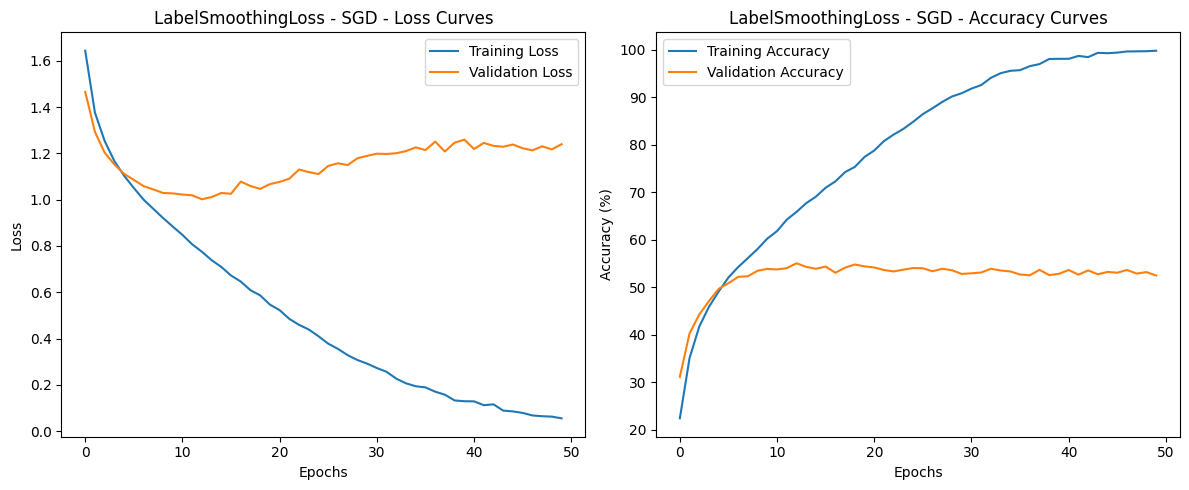

Model saved to model/cifar10_fcnn_LabelSmoothingLoss_SGD.pth


In [22]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = LabelSmoothingLoss(classes=10)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

### Label Smoothing Loss + Adagrad

Running experiment with LabelSmoothingLoss, Adagrad


Epoch 1/50: 100%|██████████| 157/157 [00:02<00:00, 54.63it/s, loss: 1.3661 - acc: 38.65%]


Epoch 1/50 - loss: 1.3661 - acc: 38.65% - val_loss: 1.2126 - val_acc: 44.06%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 56.18it/s, loss: 1.1161 - acc: 48.43%]


Epoch 2/50 - loss: 1.1161 - acc: 48.43% - val_loss: 1.1500 - val_acc: 47.54%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 56.80it/s, loss: 1.0268 - acc: 53.02%]


Epoch 3/50 - loss: 1.0268 - acc: 53.02% - val_loss: 1.1606 - val_acc: 46.36%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 56.25it/s, loss: 0.9596 - acc: 56.50%]


Epoch 4/50 - loss: 0.9596 - acc: 56.50% - val_loss: 1.1824 - val_acc: 47.41%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 56.05it/s, loss: 0.8995 - acc: 59.52%]


Epoch 5/50 - loss: 0.8995 - acc: 59.52% - val_loss: 1.1180 - val_acc: 49.92%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 56.84it/s, loss: 0.8486 - acc: 62.13%]


Epoch 6/50 - loss: 0.8486 - acc: 62.13% - val_loss: 1.0873 - val_acc: 50.94%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 55.79it/s, loss: 0.8007 - acc: 64.45%]


Epoch 7/50 - loss: 0.8007 - acc: 64.45% - val_loss: 1.0873 - val_acc: 51.65%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 56.18it/s, loss: 0.7534 - acc: 67.00%]


Epoch 8/50 - loss: 0.7534 - acc: 67.00% - val_loss: 1.0716 - val_acc: 52.54%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 56.79it/s, loss: 0.7080 - acc: 69.22%]


Epoch 9/50 - loss: 0.7080 - acc: 69.22% - val_loss: 1.1339 - val_acc: 51.01%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 57.00it/s, loss: 0.6701 - acc: 71.30%]


Epoch 10/50 - loss: 0.6701 - acc: 71.30% - val_loss: 1.0977 - val_acc: 52.42%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 56.33it/s, loss: 0.6277 - acc: 73.58%]


Epoch 11/50 - loss: 0.6277 - acc: 73.58% - val_loss: 1.1112 - val_acc: 53.25%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 56.23it/s, loss: 0.5915 - acc: 75.43%]


Epoch 12/50 - loss: 0.5915 - acc: 75.43% - val_loss: 1.1040 - val_acc: 52.96%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 57.00it/s, loss: 0.5531 - acc: 77.70%]


Epoch 13/50 - loss: 0.5531 - acc: 77.70% - val_loss: 1.1122 - val_acc: 53.80%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 55.22it/s, loss: 0.5183 - acc: 79.47%]


Epoch 14/50 - loss: 0.5183 - acc: 79.47% - val_loss: 1.2168 - val_acc: 51.02%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 55.97it/s, loss: 0.4859 - acc: 81.34%]


Epoch 15/50 - loss: 0.4859 - acc: 81.34% - val_loss: 1.1349 - val_acc: 53.70%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 55.65it/s, loss: 0.4534 - acc: 83.17%]


Epoch 16/50 - loss: 0.4534 - acc: 83.17% - val_loss: 1.1593 - val_acc: 53.37%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 56.81it/s, loss: 0.4247 - acc: 84.64%]


Epoch 17/50 - loss: 0.4247 - acc: 84.64% - val_loss: 1.1453 - val_acc: 53.99%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 56.17it/s, loss: 0.3918 - acc: 86.56%]


Epoch 18/50 - loss: 0.3918 - acc: 86.56% - val_loss: 1.2082 - val_acc: 52.37%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 56.10it/s, loss: 0.3670 - acc: 87.71%]


Epoch 19/50 - loss: 0.3670 - acc: 87.71% - val_loss: 1.2017 - val_acc: 53.52%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 56.70it/s, loss: 0.3454 - acc: 88.91%]


Epoch 20/50 - loss: 0.3454 - acc: 88.91% - val_loss: 1.2260 - val_acc: 52.53%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 56.22it/s, loss: 0.3219 - acc: 90.13%]


Epoch 21/50 - loss: 0.3219 - acc: 90.13% - val_loss: 1.1885 - val_acc: 53.42%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 56.32it/s, loss: 0.3006 - acc: 91.32%]


Epoch 22/50 - loss: 0.3006 - acc: 91.32% - val_loss: 1.2400 - val_acc: 52.83%


Epoch 23/50: 100%|██████████| 157/157 [00:03<00:00, 51.76it/s, loss: 0.2828 - acc: 92.30%]


Epoch 23/50 - loss: 0.2828 - acc: 92.30% - val_loss: 1.2899 - val_acc: 51.64%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 53.14it/s, loss: 0.2618 - acc: 93.44%]


Epoch 24/50 - loss: 0.2618 - acc: 93.44% - val_loss: 1.3431 - val_acc: 51.60%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 53.20it/s, loss: 0.2500 - acc: 93.94%]


Epoch 25/50 - loss: 0.2500 - acc: 93.94% - val_loss: 1.3187 - val_acc: 51.97%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 53.44it/s, loss: 0.2317 - acc: 94.80%]


Epoch 26/50 - loss: 0.2317 - acc: 94.80% - val_loss: 1.2580 - val_acc: 52.60%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 53.84it/s, loss: 0.2163 - acc: 95.39%]


Epoch 27/50 - loss: 0.2163 - acc: 95.39% - val_loss: 1.3434 - val_acc: 51.54%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 53.26it/s, loss: 0.2039 - acc: 96.03%]


Epoch 28/50 - loss: 0.2039 - acc: 96.03% - val_loss: 1.2594 - val_acc: 52.78%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 53.05it/s, loss: 0.1904 - acc: 96.64%]


Epoch 29/50 - loss: 0.1904 - acc: 96.64% - val_loss: 1.3561 - val_acc: 51.82%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 53.42it/s, loss: 0.1839 - acc: 96.95%]


Epoch 30/50 - loss: 0.1839 - acc: 96.95% - val_loss: 1.4592 - val_acc: 48.58%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 53.31it/s, loss: 0.1702 - acc: 97.45%]


Epoch 31/50 - loss: 0.1702 - acc: 97.45% - val_loss: 1.3245 - val_acc: 51.75%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 53.45it/s, loss: 0.1586 - acc: 97.89%]


Epoch 32/50 - loss: 0.1586 - acc: 97.89% - val_loss: 1.3236 - val_acc: 51.00%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 52.85it/s, loss: 0.1503 - acc: 98.15%]


Epoch 33/50 - loss: 0.1503 - acc: 98.15% - val_loss: 1.3487 - val_acc: 51.96%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 53.08it/s, loss: 0.1421 - acc: 98.44%]


Epoch 34/50 - loss: 0.1421 - acc: 98.44% - val_loss: 1.3039 - val_acc: 52.83%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 53.88it/s, loss: 0.1354 - acc: 98.57%]


Epoch 35/50 - loss: 0.1354 - acc: 98.57% - val_loss: 1.3029 - val_acc: 52.52%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 53.12it/s, loss: 0.1286 - acc: 98.78%]


Epoch 36/50 - loss: 0.1286 - acc: 98.78% - val_loss: 1.3325 - val_acc: 51.30%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 53.28it/s, loss: 0.1223 - acc: 98.95%]


Epoch 37/50 - loss: 0.1223 - acc: 98.95% - val_loss: 1.3169 - val_acc: 52.24%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 53.48it/s, loss: 0.1174 - acc: 99.05%]


Epoch 38/50 - loss: 0.1174 - acc: 99.05% - val_loss: 1.3083 - val_acc: 52.26%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 53.38it/s, loss: 0.1102 - acc: 99.23%]


Epoch 39/50 - loss: 0.1102 - acc: 99.23% - val_loss: 1.3127 - val_acc: 52.35%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 53.57it/s, loss: 0.1058 - acc: 99.29%]


Epoch 40/50 - loss: 0.1058 - acc: 99.29% - val_loss: 1.3294 - val_acc: 52.63%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 53.94it/s, loss: 0.1021 - acc: 99.36%]


Epoch 41/50 - loss: 0.1021 - acc: 99.36% - val_loss: 1.3051 - val_acc: 52.46%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 53.63it/s, loss: 0.0968 - acc: 99.45%]


Epoch 42/50 - loss: 0.0968 - acc: 99.45% - val_loss: 1.3451 - val_acc: 51.53%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 53.66it/s, loss: 0.0939 - acc: 99.50%]


Epoch 43/50 - loss: 0.0939 - acc: 99.50% - val_loss: 1.3898 - val_acc: 50.89%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 53.60it/s, loss: 0.0910 - acc: 99.51%]


Epoch 44/50 - loss: 0.0910 - acc: 99.51% - val_loss: 1.3157 - val_acc: 52.17%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 53.41it/s, loss: 0.0865 - acc: 99.61%]


Epoch 45/50 - loss: 0.0865 - acc: 99.61% - val_loss: 1.3298 - val_acc: 52.30%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 53.45it/s, loss: 0.0825 - acc: 99.66%]


Epoch 46/50 - loss: 0.0825 - acc: 99.66% - val_loss: 1.3236 - val_acc: 52.30%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 54.12it/s, loss: 0.0802 - acc: 99.67%]


Epoch 47/50 - loss: 0.0802 - acc: 99.67% - val_loss: 1.3168 - val_acc: 52.64%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 52.59it/s, loss: 0.0771 - acc: 99.71%]


Epoch 48/50 - loss: 0.0771 - acc: 99.71% - val_loss: 1.3381 - val_acc: 52.05%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 53.60it/s, loss: 0.0746 - acc: 99.72%]


Epoch 49/50 - loss: 0.0746 - acc: 99.72% - val_loss: 1.3260 - val_acc: 51.94%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 53.45it/s, loss: 0.0720 - acc: 99.78%]


Epoch 50/50 - loss: 0.0720 - acc: 99.78% - val_loss: 1.3281 - val_acc: 52.30%
Training completed in 173.45 seconds
Test Accuracy: 52.30%
Accuracy of plane: 61.35%
Accuracy of car: 67.11%
Accuracy of bird: 38.15%
Accuracy of cat: 32.29%
Accuracy of deer: 50.31%
Accuracy of dog: 48.07%
Accuracy of frog: 50.72%
Accuracy of horse: 52.37%
Accuracy of ship: 71.40%
Accuracy of truck: 52.01%
Test Accuracy: 52.30%


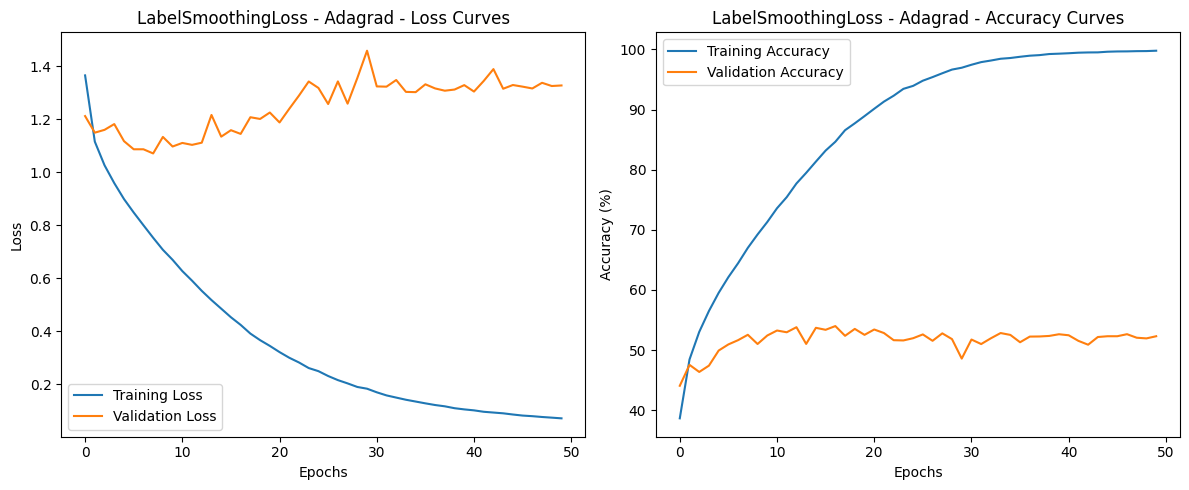

Model saved to model/cifar10_fcnn_LabelSmoothingLoss_Adagrad.pth


In [23]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = LabelSmoothingLoss(classes=10)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

### Label Smoothing Loss + Adam

Running experiment with LabelSmoothingLoss, Adam


Epoch 1/50: 100%|██████████| 157/157 [00:02<00:00, 53.51it/s, loss: 1.2992 - acc: 38.92%]


Epoch 1/50 - loss: 1.2992 - acc: 38.92% - val_loss: 1.1750 - val_acc: 45.78%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 54.93it/s, loss: 1.1189 - acc: 48.45%]


Epoch 2/50 - loss: 1.1189 - acc: 48.45% - val_loss: 1.1072 - val_acc: 49.31%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 54.29it/s, loss: 1.0281 - acc: 52.91%]


Epoch 3/50 - loss: 1.0281 - acc: 52.91% - val_loss: 1.0639 - val_acc: 51.76%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 54.21it/s, loss: 0.9500 - acc: 56.82%]


Epoch 4/50 - loss: 0.9500 - acc: 56.82% - val_loss: 1.0453 - val_acc: 52.59%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 54.47it/s, loss: 0.8893 - acc: 59.84%]


Epoch 5/50 - loss: 0.8893 - acc: 59.84% - val_loss: 1.0451 - val_acc: 53.27%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 54.57it/s, loss: 0.8277 - acc: 62.92%]


Epoch 6/50 - loss: 0.8277 - acc: 62.92% - val_loss: 1.0263 - val_acc: 54.56%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 54.40it/s, loss: 0.7597 - acc: 65.97%]


Epoch 7/50 - loss: 0.7597 - acc: 65.97% - val_loss: 1.0470 - val_acc: 54.25%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 54.29it/s, loss: 0.7012 - acc: 69.26%]


Epoch 8/50 - loss: 0.7012 - acc: 69.26% - val_loss: 1.0638 - val_acc: 53.21%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 53.84it/s, loss: 0.6442 - acc: 72.27%]


Epoch 9/50 - loss: 0.6442 - acc: 72.27% - val_loss: 1.0791 - val_acc: 54.12%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 54.80it/s, loss: 0.5848 - acc: 75.20%]


Epoch 10/50 - loss: 0.5848 - acc: 75.20% - val_loss: 1.1063 - val_acc: 54.20%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 54.51it/s, loss: 0.5278 - acc: 77.99%]


Epoch 11/50 - loss: 0.5278 - acc: 77.99% - val_loss: 1.1369 - val_acc: 54.17%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 54.10it/s, loss: 0.4729 - acc: 81.06%]


Epoch 12/50 - loss: 0.4729 - acc: 81.06% - val_loss: 1.1392 - val_acc: 53.50%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 54.99it/s, loss: 0.4271 - acc: 83.48%]


Epoch 13/50 - loss: 0.4271 - acc: 83.48% - val_loss: 1.1727 - val_acc: 52.92%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 54.99it/s, loss: 0.3815 - acc: 86.04%]


Epoch 14/50 - loss: 0.3815 - acc: 86.04% - val_loss: 1.2126 - val_acc: 53.67%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 54.04it/s, loss: 0.3390 - acc: 88.22%]


Epoch 15/50 - loss: 0.3390 - acc: 88.22% - val_loss: 1.2523 - val_acc: 53.61%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 54.26it/s, loss: 0.3064 - acc: 89.68%]


Epoch 16/50 - loss: 0.3064 - acc: 89.68% - val_loss: 1.2212 - val_acc: 53.65%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 54.99it/s, loss: 0.2684 - acc: 91.71%]


Epoch 17/50 - loss: 0.2684 - acc: 91.71% - val_loss: 1.2591 - val_acc: 53.74%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 54.35it/s, loss: 0.2474 - acc: 92.85%]


Epoch 18/50 - loss: 0.2474 - acc: 92.85% - val_loss: 1.2698 - val_acc: 53.93%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 54.45it/s, loss: 0.2247 - acc: 93.84%]


Epoch 19/50 - loss: 0.2247 - acc: 93.84% - val_loss: 1.2738 - val_acc: 53.76%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 54.28it/s, loss: 0.1955 - acc: 95.22%]


Epoch 20/50 - loss: 0.1955 - acc: 95.22% - val_loss: 1.2916 - val_acc: 53.77%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 54.95it/s, loss: 0.1774 - acc: 95.84%]


Epoch 21/50 - loss: 0.1774 - acc: 95.84% - val_loss: 1.3106 - val_acc: 53.61%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 54.14it/s, loss: 0.1608 - acc: 96.74%]


Epoch 22/50 - loss: 0.1608 - acc: 96.74% - val_loss: 1.2808 - val_acc: 53.60%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 54.11it/s, loss: 0.1448 - acc: 97.27%]


Epoch 23/50 - loss: 0.1448 - acc: 97.27% - val_loss: 1.2815 - val_acc: 54.04%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 54.39it/s, loss: 0.1314 - acc: 97.81%]


Epoch 24/50 - loss: 0.1314 - acc: 97.81% - val_loss: 1.2857 - val_acc: 53.66%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 54.81it/s, loss: 0.1206 - acc: 98.11%]


Epoch 25/50 - loss: 0.1206 - acc: 98.11% - val_loss: 1.3298 - val_acc: 53.65%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 54.37it/s, loss: 0.1244 - acc: 97.92%]


Epoch 26/50 - loss: 0.1244 - acc: 97.92% - val_loss: 1.3068 - val_acc: 53.57%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 54.44it/s, loss: 0.1135 - acc: 98.27%]


Epoch 27/50 - loss: 0.1135 - acc: 98.27% - val_loss: 1.3239 - val_acc: 52.99%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 54.55it/s, loss: 0.1168 - acc: 98.11%]


Epoch 28/50 - loss: 0.1168 - acc: 98.11% - val_loss: 1.3080 - val_acc: 53.69%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 55.03it/s, loss: 0.1060 - acc: 98.43%]


Epoch 29/50 - loss: 0.1060 - acc: 98.43% - val_loss: 1.3149 - val_acc: 53.12%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 54.30it/s, loss: 0.1048 - acc: 98.50%]


Epoch 30/50 - loss: 0.1048 - acc: 98.50% - val_loss: 1.2992 - val_acc: 53.37%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 54.32it/s, loss: 0.0974 - acc: 98.58%]


Epoch 31/50 - loss: 0.0974 - acc: 98.58% - val_loss: 1.3659 - val_acc: 52.25%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 54.73it/s, loss: 0.1189 - acc: 97.80%]


Epoch 32/50 - loss: 0.1189 - acc: 97.80% - val_loss: 1.3277 - val_acc: 53.24%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 54.36it/s, loss: 0.1130 - acc: 98.00%]


Epoch 33/50 - loss: 0.1130 - acc: 98.00% - val_loss: 1.3197 - val_acc: 52.88%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 54.39it/s, loss: 0.1079 - acc: 98.24%]


Epoch 34/50 - loss: 0.1079 - acc: 98.24% - val_loss: 1.3212 - val_acc: 53.13%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 54.28it/s, loss: 0.0834 - acc: 98.94%]


Epoch 35/50 - loss: 0.0834 - acc: 98.94% - val_loss: 1.3006 - val_acc: 53.31%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 55.05it/s, loss: 0.0633 - acc: 99.49%]


Epoch 36/50 - loss: 0.0633 - acc: 99.49% - val_loss: 1.2677 - val_acc: 53.57%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 54.38it/s, loss: 0.0549 - acc: 99.66%]


Epoch 37/50 - loss: 0.0549 - acc: 99.66% - val_loss: 1.2702 - val_acc: 53.64%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 54.45it/s, loss: 0.0483 - acc: 99.75%]


Epoch 38/50 - loss: 0.0483 - acc: 99.75% - val_loss: 1.2272 - val_acc: 53.56%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 55.04it/s, loss: 0.0597 - acc: 99.45%]


Epoch 39/50 - loss: 0.0597 - acc: 99.45% - val_loss: 1.2969 - val_acc: 52.86%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 52.77it/s, loss: 0.1513 - acc: 95.89%]


Epoch 40/50 - loss: 0.1513 - acc: 95.89% - val_loss: 1.4042 - val_acc: 50.91%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 54.21it/s, loss: 0.2142 - acc: 93.11%]


Epoch 41/50 - loss: 0.2142 - acc: 93.11% - val_loss: 1.3957 - val_acc: 51.89%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 54.18it/s, loss: 0.1104 - acc: 97.85%]


Epoch 42/50 - loss: 0.1104 - acc: 97.85% - val_loss: 1.2962 - val_acc: 53.45%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 55.01it/s, loss: 0.0580 - acc: 99.57%]


Epoch 43/50 - loss: 0.0580 - acc: 99.57% - val_loss: 1.2309 - val_acc: 53.99%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 54.36it/s, loss: 0.0376 - acc: 99.88%]


Epoch 44/50 - loss: 0.0376 - acc: 99.88% - val_loss: 1.2313 - val_acc: 54.33%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 54.38it/s, loss: 0.0280 - acc: 99.93%]


Epoch 45/50 - loss: 0.0280 - acc: 99.93% - val_loss: 1.2258 - val_acc: 54.34%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 54.36it/s, loss: 0.0253 - acc: 99.92%]


Epoch 46/50 - loss: 0.0253 - acc: 99.92% - val_loss: 1.2059 - val_acc: 54.33%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 55.01it/s, loss: 0.0207 - acc: 99.97%]


Epoch 47/50 - loss: 0.0207 - acc: 99.97% - val_loss: 1.2101 - val_acc: 54.06%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 54.36it/s, loss: 0.0216 - acc: 99.94%]


Epoch 48/50 - loss: 0.0216 - acc: 99.94% - val_loss: 1.2183 - val_acc: 54.28%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 53.81it/s, loss: 0.0218 - acc: 99.94%]


Epoch 49/50 - loss: 0.0218 - acc: 99.94% - val_loss: 1.2253 - val_acc: 54.03%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 54.97it/s, loss: 0.0447 - acc: 99.41%]


Epoch 50/50 - loss: 0.0447 - acc: 99.41% - val_loss: 1.3671 - val_acc: 52.03%
Training completed in 173.85 seconds
Test Accuracy: 52.03%
Accuracy of plane: 55.70%
Accuracy of car: 62.35%
Accuracy of bird: 40.64%
Accuracy of cat: 34.44%
Accuracy of deer: 33.64%
Accuracy of dog: 44.82%
Accuracy of frog: 62.39%
Accuracy of horse: 55.33%
Accuracy of ship: 77.30%
Accuracy of truck: 53.35%
Test Accuracy: 52.03%


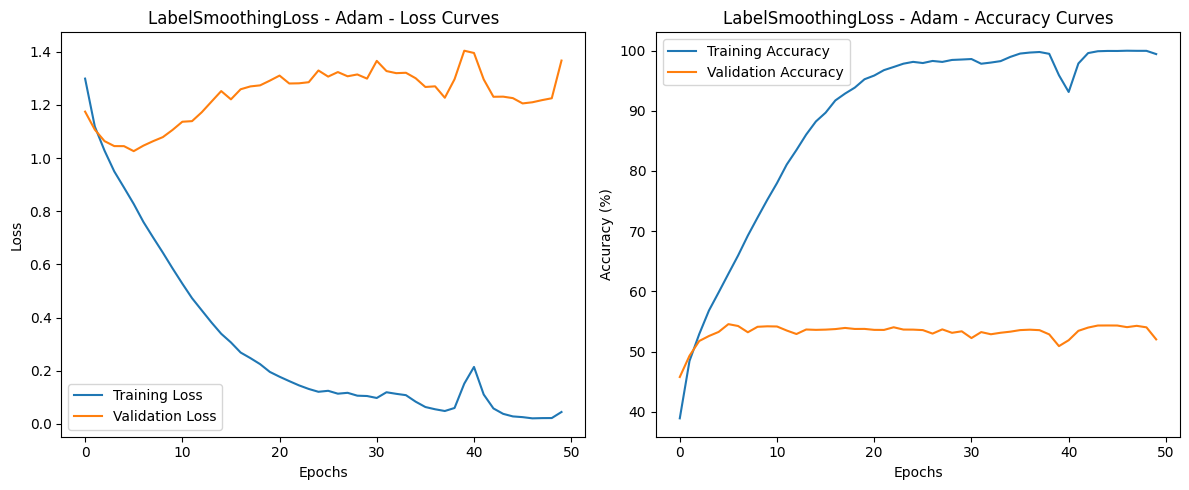

Model saved to model/cifar10_fcnn_LabelSmoothingLoss_Adam.pth


In [24]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = LabelSmoothingLoss(classes=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

### Label Smoothing Loss + Adamax

Running experiment with LabelSmoothingLoss, Adamax


Epoch 1/50: 100%|██████████| 157/157 [00:02<00:00, 52.87it/s, loss: 1.3070 - acc: 39.01%]


Epoch 1/50 - loss: 1.3070 - acc: 39.01% - val_loss: 1.1854 - val_acc: 45.73%


Epoch 2/50: 100%|██████████| 157/157 [00:02<00:00, 54.63it/s, loss: 1.1373 - acc: 47.47%]


Epoch 2/50 - loss: 1.1373 - acc: 47.47% - val_loss: 1.1353 - val_acc: 47.72%


Epoch 3/50: 100%|██████████| 157/157 [00:02<00:00, 55.29it/s, loss: 1.0578 - acc: 51.69%]


Epoch 3/50 - loss: 1.0578 - acc: 51.69% - val_loss: 1.0881 - val_acc: 50.25%


Epoch 4/50: 100%|██████████| 157/157 [00:02<00:00, 54.34it/s, loss: 0.9950 - acc: 54.60%]


Epoch 4/50 - loss: 0.9950 - acc: 54.60% - val_loss: 1.0541 - val_acc: 51.90%


Epoch 5/50: 100%|██████████| 157/157 [00:02<00:00, 54.38it/s, loss: 0.9399 - acc: 57.44%]


Epoch 5/50 - loss: 0.9399 - acc: 57.44% - val_loss: 1.0400 - val_acc: 52.88%


Epoch 6/50: 100%|██████████| 157/157 [00:02<00:00, 54.60it/s, loss: 0.8851 - acc: 60.23%]


Epoch 6/50 - loss: 0.8851 - acc: 60.23% - val_loss: 1.0211 - val_acc: 53.41%


Epoch 7/50: 100%|██████████| 157/157 [00:02<00:00, 55.30it/s, loss: 0.8391 - acc: 62.53%]


Epoch 7/50 - loss: 0.8391 - acc: 62.53% - val_loss: 1.0243 - val_acc: 54.04%


Epoch 8/50: 100%|██████████| 157/157 [00:02<00:00, 54.60it/s, loss: 0.7931 - acc: 65.23%]


Epoch 8/50 - loss: 0.7931 - acc: 65.23% - val_loss: 1.0094 - val_acc: 54.70%


Epoch 9/50: 100%|██████████| 157/157 [00:02<00:00, 54.68it/s, loss: 0.7458 - acc: 67.40%]


Epoch 9/50 - loss: 0.7458 - acc: 67.40% - val_loss: 1.0179 - val_acc: 54.92%


Epoch 10/50: 100%|██████████| 157/157 [00:02<00:00, 54.63it/s, loss: 0.7046 - acc: 69.46%]


Epoch 10/50 - loss: 0.7046 - acc: 69.46% - val_loss: 1.0185 - val_acc: 55.32%


Epoch 11/50: 100%|██████████| 157/157 [00:02<00:00, 55.23it/s, loss: 0.6613 - acc: 71.66%]


Epoch 11/50 - loss: 0.6613 - acc: 71.66% - val_loss: 1.0265 - val_acc: 55.03%


Epoch 12/50: 100%|██████████| 157/157 [00:02<00:00, 54.72it/s, loss: 0.6191 - acc: 73.97%]


Epoch 12/50 - loss: 0.6191 - acc: 73.97% - val_loss: 1.0416 - val_acc: 55.31%


Epoch 13/50: 100%|██████████| 157/157 [00:02<00:00, 54.22it/s, loss: 0.5766 - acc: 76.22%]


Epoch 13/50 - loss: 0.5766 - acc: 76.22% - val_loss: 1.0531 - val_acc: 54.80%


Epoch 14/50: 100%|██████████| 157/157 [00:02<00:00, 55.07it/s, loss: 0.5405 - acc: 78.06%]


Epoch 14/50 - loss: 0.5405 - acc: 78.06% - val_loss: 1.0676 - val_acc: 55.06%


Epoch 15/50: 100%|██████████| 157/157 [00:02<00:00, 54.59it/s, loss: 0.4971 - acc: 80.72%]


Epoch 15/50 - loss: 0.4971 - acc: 80.72% - val_loss: 1.1000 - val_acc: 54.33%


Epoch 16/50: 100%|██████████| 157/157 [00:02<00:00, 54.43it/s, loss: 0.4651 - acc: 82.32%]


Epoch 16/50 - loss: 0.4651 - acc: 82.32% - val_loss: 1.0706 - val_acc: 54.93%


Epoch 17/50: 100%|██████████| 157/157 [00:02<00:00, 54.55it/s, loss: 0.4315 - acc: 83.98%]


Epoch 17/50 - loss: 0.4315 - acc: 83.98% - val_loss: 1.1135 - val_acc: 54.74%


Epoch 18/50: 100%|██████████| 157/157 [00:02<00:00, 55.35it/s, loss: 0.3995 - acc: 85.58%]


Epoch 18/50 - loss: 0.3995 - acc: 85.58% - val_loss: 1.1284 - val_acc: 54.25%


Epoch 19/50: 100%|██████████| 157/157 [00:02<00:00, 54.76it/s, loss: 0.3684 - acc: 87.55%]


Epoch 19/50 - loss: 0.3684 - acc: 87.55% - val_loss: 1.1499 - val_acc: 54.44%


Epoch 20/50: 100%|██████████| 157/157 [00:02<00:00, 54.62it/s, loss: 0.3410 - acc: 88.82%]


Epoch 20/50 - loss: 0.3410 - acc: 88.82% - val_loss: 1.1634 - val_acc: 54.78%


Epoch 21/50: 100%|██████████| 157/157 [00:02<00:00, 54.60it/s, loss: 0.3146 - acc: 90.30%]


Epoch 21/50 - loss: 0.3146 - acc: 90.30% - val_loss: 1.1807 - val_acc: 54.41%


Epoch 22/50: 100%|██████████| 157/157 [00:02<00:00, 55.31it/s, loss: 0.2866 - acc: 91.88%]


Epoch 22/50 - loss: 0.2866 - acc: 91.88% - val_loss: 1.1991 - val_acc: 54.15%


Epoch 23/50: 100%|██████████| 157/157 [00:02<00:00, 54.57it/s, loss: 0.2666 - acc: 92.82%]


Epoch 23/50 - loss: 0.2666 - acc: 92.82% - val_loss: 1.2148 - val_acc: 54.47%


Epoch 24/50: 100%|██████████| 157/157 [00:02<00:00, 54.60it/s, loss: 0.2462 - acc: 93.68%]


Epoch 24/50 - loss: 0.2462 - acc: 93.68% - val_loss: 1.2297 - val_acc: 53.78%


Epoch 25/50: 100%|██████████| 157/157 [00:02<00:00, 54.76it/s, loss: 0.2269 - acc: 94.70%]


Epoch 25/50 - loss: 0.2269 - acc: 94.70% - val_loss: 1.2198 - val_acc: 53.15%


Epoch 26/50: 100%|██████████| 157/157 [00:02<00:00, 55.30it/s, loss: 0.2040 - acc: 95.76%]


Epoch 26/50 - loss: 0.2040 - acc: 95.76% - val_loss: 1.2433 - val_acc: 54.20%


Epoch 27/50: 100%|██████████| 157/157 [00:02<00:00, 54.61it/s, loss: 0.1965 - acc: 95.94%]


Epoch 27/50 - loss: 0.1965 - acc: 95.94% - val_loss: 1.2555 - val_acc: 53.19%


Epoch 28/50: 100%|██████████| 157/157 [00:02<00:00, 54.44it/s, loss: 0.1753 - acc: 96.84%]


Epoch 28/50 - loss: 0.1753 - acc: 96.84% - val_loss: 1.2785 - val_acc: 53.48%


Epoch 29/50: 100%|██████████| 157/157 [00:02<00:00, 55.25it/s, loss: 0.1677 - acc: 97.08%]


Epoch 29/50 - loss: 0.1677 - acc: 97.08% - val_loss: 1.2945 - val_acc: 53.51%


Epoch 30/50: 100%|██████████| 157/157 [00:02<00:00, 54.20it/s, loss: 0.1685 - acc: 96.96%]


Epoch 30/50 - loss: 0.1685 - acc: 96.96% - val_loss: 1.2879 - val_acc: 53.50%


Epoch 31/50: 100%|██████████| 157/157 [00:02<00:00, 53.44it/s, loss: 0.1411 - acc: 98.17%]


Epoch 31/50 - loss: 0.1411 - acc: 98.17% - val_loss: 1.2851 - val_acc: 53.54%


Epoch 32/50: 100%|██████████| 157/157 [00:02<00:00, 55.15it/s, loss: 0.1321 - acc: 98.36%]


Epoch 32/50 - loss: 0.1321 - acc: 98.36% - val_loss: 1.2787 - val_acc: 53.55%


Epoch 33/50: 100%|██████████| 157/157 [00:02<00:00, 55.89it/s, loss: 0.1336 - acc: 98.23%]


Epoch 33/50 - loss: 0.1336 - acc: 98.23% - val_loss: 1.2786 - val_acc: 53.24%


Epoch 34/50: 100%|██████████| 157/157 [00:02<00:00, 55.11it/s, loss: 0.1239 - acc: 98.50%]


Epoch 34/50 - loss: 0.1239 - acc: 98.50% - val_loss: 1.3083 - val_acc: 52.79%


Epoch 35/50: 100%|██████████| 157/157 [00:02<00:00, 55.24it/s, loss: 0.1155 - acc: 98.74%]


Epoch 35/50 - loss: 0.1155 - acc: 98.74% - val_loss: 1.3243 - val_acc: 52.80%


Epoch 36/50: 100%|██████████| 157/157 [00:02<00:00, 55.45it/s, loss: 0.0995 - acc: 99.17%]


Epoch 36/50 - loss: 0.0995 - acc: 99.17% - val_loss: 1.2723 - val_acc: 53.30%


Epoch 37/50: 100%|██████████| 157/157 [00:02<00:00, 55.70it/s, loss: 0.0970 - acc: 99.17%]


Epoch 37/50 - loss: 0.0970 - acc: 99.17% - val_loss: 1.2914 - val_acc: 52.96%


Epoch 38/50: 100%|██████████| 157/157 [00:02<00:00, 54.91it/s, loss: 0.0962 - acc: 99.20%]


Epoch 38/50 - loss: 0.0962 - acc: 99.20% - val_loss: 1.3001 - val_acc: 53.05%


Epoch 39/50: 100%|██████████| 157/157 [00:02<00:00, 55.06it/s, loss: 0.0867 - acc: 99.36%]


Epoch 39/50 - loss: 0.0867 - acc: 99.36% - val_loss: 1.2844 - val_acc: 53.62%


Epoch 40/50: 100%|██████████| 157/157 [00:02<00:00, 55.48it/s, loss: 0.0858 - acc: 99.39%]


Epoch 40/50 - loss: 0.0858 - acc: 99.39% - val_loss: 1.2954 - val_acc: 53.45%


Epoch 41/50: 100%|██████████| 157/157 [00:02<00:00, 55.18it/s, loss: 0.0833 - acc: 99.40%]


Epoch 41/50 - loss: 0.0833 - acc: 99.40% - val_loss: 1.3043 - val_acc: 52.80%


Epoch 42/50: 100%|██████████| 157/157 [00:02<00:00, 55.13it/s, loss: 0.0803 - acc: 99.47%]


Epoch 42/50 - loss: 0.0803 - acc: 99.47% - val_loss: 1.2865 - val_acc: 53.55%


Epoch 43/50: 100%|██████████| 157/157 [00:02<00:00, 55.76it/s, loss: 0.0771 - acc: 99.50%]


Epoch 43/50 - loss: 0.0771 - acc: 99.50% - val_loss: 1.2592 - val_acc: 53.62%


Epoch 44/50: 100%|██████████| 157/157 [00:02<00:00, 55.71it/s, loss: 0.0646 - acc: 99.72%]


Epoch 44/50 - loss: 0.0646 - acc: 99.72% - val_loss: 1.2739 - val_acc: 53.61%


Epoch 45/50: 100%|██████████| 157/157 [00:02<00:00, 55.18it/s, loss: 0.0687 - acc: 99.61%]


Epoch 45/50 - loss: 0.0687 - acc: 99.61% - val_loss: 1.2546 - val_acc: 53.83%


Epoch 46/50: 100%|██████████| 157/157 [00:02<00:00, 55.01it/s, loss: 0.0636 - acc: 99.69%]


Epoch 46/50 - loss: 0.0636 - acc: 99.69% - val_loss: 1.2676 - val_acc: 53.39%


Epoch 47/50: 100%|██████████| 157/157 [00:02<00:00, 55.84it/s, loss: 0.0641 - acc: 99.66%]


Epoch 47/50 - loss: 0.0641 - acc: 99.66% - val_loss: 1.3186 - val_acc: 52.42%


Epoch 48/50: 100%|██████████| 157/157 [00:02<00:00, 54.96it/s, loss: 0.0549 - acc: 99.78%]


Epoch 48/50 - loss: 0.0549 - acc: 99.78% - val_loss: 1.2680 - val_acc: 53.38%


Epoch 49/50: 100%|██████████| 157/157 [00:02<00:00, 54.81it/s, loss: 0.0518 - acc: 99.80%]


Epoch 49/50 - loss: 0.0518 - acc: 99.80% - val_loss: 1.2691 - val_acc: 53.57%


Epoch 50/50: 100%|██████████| 157/157 [00:02<00:00, 55.70it/s, loss: 0.0586 - acc: 99.73%]


Epoch 50/50 - loss: 0.0586 - acc: 99.73% - val_loss: 1.2890 - val_acc: 52.77%
Training completed in 172.59 seconds
Test Accuracy: 52.77%
Accuracy of plane: 60.65%
Accuracy of car: 62.35%
Accuracy of bird: 36.75%
Accuracy of cat: 31.22%
Accuracy of deer: 49.49%
Accuracy of dog: 45.93%
Accuracy of frog: 60.86%
Accuracy of horse: 56.11%
Accuracy of ship: 68.30%
Accuracy of truck: 56.33%
Test Accuracy: 52.77%


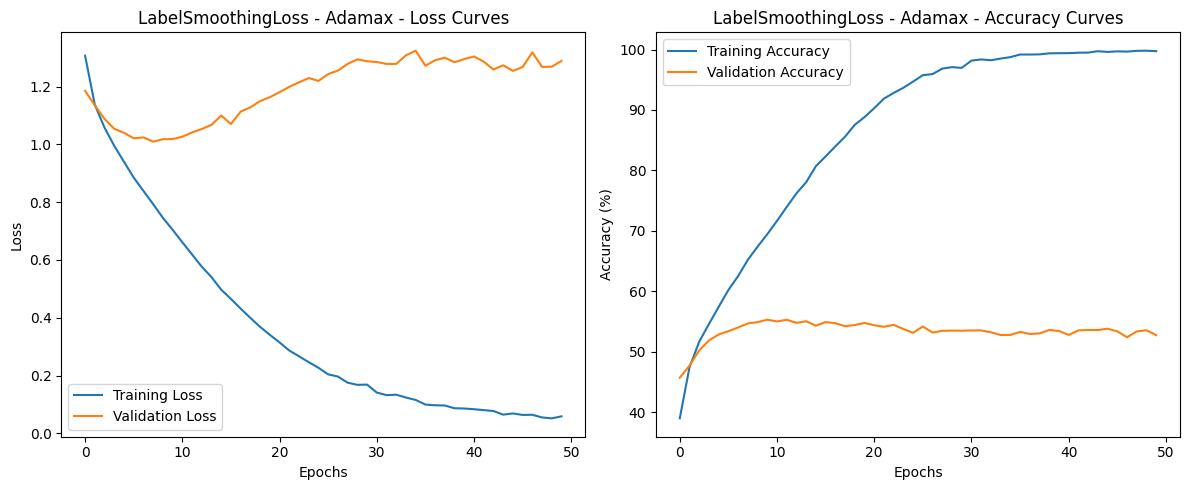

Model saved to model/cifar10_fcnn_LabelSmoothingLoss_Adamax.pth


In [25]:
model = FullyConnectedNN(input_size, hidden_sizes, num_classes).to(device)
loss_fn = LabelSmoothingLoss(classes=10)
optimizer = optim.Adamax(model.parameters(), lr=0.001)

experiment(
    model,
    train_loader,
    val_loader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)